In [66]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
from datetime import datetime, timedelta
from matplotlib.lines import Line2D
import statsmodels.api as sm
import warnings
from pandas.errors import SettingWithCopyWarning
# Suppress specific warnings
warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


In [43]:
data_df = pd.read_csv("data.csv")
data_df.head()

,Date,Taxonomy,Campaign ID,Traffic,Ad impressions,CPM,Ad spend,Booking Lead Time,Sales
0,2021-12-27,Appliances,789.0,"186,565","111,939",$ 36,"$ 3,994,543",7.0,"$ 27,961,803"
1,2022-01-03,Appliances,2503.0,"735,673","426,690",$ 43,"$ 18,357,057",10.0,"$ 348,784,086"
2,2022-01-10,Appliances,4243.0,"565,996","181,119",$ 42,"$ 7,664,956",7.0,"$ 99,644,429"
3,2022-01-17,Appliances,6082.0,"778,248","326,864",$ 61,"$ 20,004,077",12.0,"$ 320,065,229"
4,2022-01-24,Appliances,8051.0,"473,789","161,088",$ 39,"$ 6,303,341",13.0,"$ 182,796,895"


### Clean Up

In [44]:
#Convert date object to datetime
data_df['Date'] = pd.to_datetime(data_df['Date'] , format='%Y-%m-%d')

#strip spaces from the headers
data_df.columns = data_df.columns.str.strip()
data_df = data_df.rename(columns = {'Date':'date', 'Taxonomy':'taxonomy', 'Campaign ID': 'campaign_id', 'Traffic':'traffic', 'Ad impressions':'ad_impressions', 'CPM':'cpm',
                                    'Ad spend':'ad_spend', 'Booking Lead Time':'booking_lead_time', 'Sales':'sales'})


# Remove spaces, commas, and non-numeric characters
data_df['traffic'] = data_df['traffic'].str.strip().str.replace(',', '')

# Now convert the cleaned values to integers
data_df['traffic'] = pd.to_numeric(data_df['traffic'], errors='coerce').astype('float')

# Clean and convert 'Ad impressions'
data_df['ad_impressions'] = data_df['ad_impressions'].str.strip().str.replace(',', '')
data_df['ad_impressions'] = pd.to_numeric(data_df['ad_impressions'], errors='coerce').astype('float')


#  Clean and convert 'CPM'
data_df['cpm'] = data_df['cpm'].str.strip().str.replace('$', '')
data_df['cpm'] = pd.to_numeric(data_df['cpm'], errors='coerce').astype('float')
# data_df['CPM'] =data_df['CPM'] .apply(lambda x: f"${x:,.2f}")

# Clean and convert 'Ad Spend'
data_df['ad_spend'] = data_df['ad_spend'].str.strip().str.replace(',', '')
data_df['ad_spend'] = data_df['ad_spend'].str.strip().str.replace('$', '')
data_df['ad_spend'] = pd.to_numeric(data_df['ad_spend'], errors='coerce').astype('float')
# # data_df['Ad spend']=data_df['Ad spend'].apply(lambda x: f"${x:,.2f}")

# Clean and convert 'Sales'
data_df['sales'] = data_df['sales'].str.strip().str.replace(',', '')
data_df['sales'] = data_df['sales'].str.strip().str.replace('$', '')
data_df['sales'] = pd.to_numeric(data_df['sales'], errors='coerce').astype('float')

#sort by date
data_df= data_df.sort_values('date')


#create a year column
data_df['year'] = data_df['date'].dt.year
data_df['month'] = data_df['date'].dt.month
data_df['year_month'] = data_df['year'].astype(str) + '-' + data_df['month'].apply(lambda x: f'{x:02d}') 

# Create a new column 'WeekNumber' with the ISO week number
data_df['week_num'] = data_df['date'].dt.isocalendar().week

In [45]:
# Drop rows where all specified columns are NaN
clean_df = data_df.dropna(subset=['ad_impressions', 'ad_spend', 'sales'], how='all')
clean_df.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52


In [46]:
#Looking for null values

clean_df[clean_df.isna().any(axis=1)]


,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num
77341,2021-12-27,Outdoors|Garden Center|Ponds & Pond Accessorie...,267.0,380.0,209.0,44.0,9154.0,9.0,NaN,2021,12,2021-12,52
228751,2022-01-17,Tools|Woodworking Tools|Wood Glue,7033.0,30080.0,14739.0,38.0,563263.0,11.0,NaN,2022,1,2022-01,3
33616,2022-01-17,Home Decor|Artificial Plants|Artificial Topiaries,6004.0,8180.0,3599.0,49.0,176531.0,12.0,NaN,2022,1,2022-01,3
85626,2022-01-31,Outdoors|Outdoor Cooking,9194.0,9550.0,5539.0,34.0,188373.0,13.0,NaN,2022,1,2022-01,5
9881,2022-02-28,Appliances|Microwaves|Over-the-Range Microwaves,16442.0,435740.0,152509.0,52.0,7985692.0,9.0,NaN,2022,2,2022-02,9
95732,2022-02-28,Outdoors|Outdoor Cooking|Outdoor Kitchens|Pizz...,15887.0,18570.0,7799.0,63.0,488295.0,9.0,NaN,2022,2,2022-02,9
11354,2022-03-21,Appliances|Ranges|Electric Ranges|Double Oven ...,21765.0,45310.0,14499.0,63.0,918504.0,11.0,NaN,2022,3,2022-03,12
220462,2022-05-09,Tools|Tool Storage|Saw Horses,34975.0,46060.0,22569.0,37.0,828878.0,8.0,NaN,2022,5,2022-05,19
51354,2022-08-08,Outdoors|Garden Center|Hardscapes|Hardscape Su...,56597.0,69510.0,27109.0,54.0,1452977.0,12.0,NaN,2022,8,2022-08,32
62359,2022-08-29,Outdoors|Garden Center|Organic Gardening|Organ...,61934.0,3610.0,1119.0,11.0,12425.0,12.0,NaN,2022,8,2022-08,35


## Exploration

In [47]:

# number of unique weeks per campaign_id
campaign_length = clean_df.groupby('campaign_id')['date'].nunique().reset_index()

campaign_length.columns = ['campaign_id', 'unique_weeks']

campaign_length.head()


,campaign_id,unique_weeks
0,1.0,1
1,3.0,1
2,6.0,1
3,7.0,1
4,8.0,1


### CPM Over Time and By Revenue

In [48]:
cpm_df = clean_df.groupby(['year', 'week_num'])['cpm'].mean()
cpm_df = pd.DataFrame(cpm_df).reset_index()
cpm_df = cpm_df[cpm_df['year'] != 2021]
cpm_df.head()

,year,week_num,cpm
1,2022,1,38.915924
2,2022,2,43.781180
3,2022,3,46.838656
4,2022,4,48.157423
5,2022,5,45.536499


In [50]:
#6 week rolling avg calculation
window_size = 6  

cpm_df['cpm_rolling_avg'] = cpm_df['cpm'].rolling(window=window_size).mean()
cpm_df.tail()

,year,week_num,cpm,cpm_rolling_avg
100,2023,48,13.456316,20.504870
101,2023,49,33.967095,20.085892
102,2023,50,34.135107,20.129223
103,2023,51,35.517653,23.751814
104,2023,52,35.606893,27.590010


In [51]:
#pivot for yearly cpm compariosn
yearly_cpm = cpm_df.pivot(index='week_num', columns='year', values='cpm')
yearly_cpm = yearly_cpm.reset_index()
yearly_cpm.head()

year,week_num,2022,2023
0,1,38.915924,47.236646
1,2,43.781180,48.699485
2,3,46.838656,33.302909
3,4,48.157423,29.025568
4,5,45.536499,50.473652


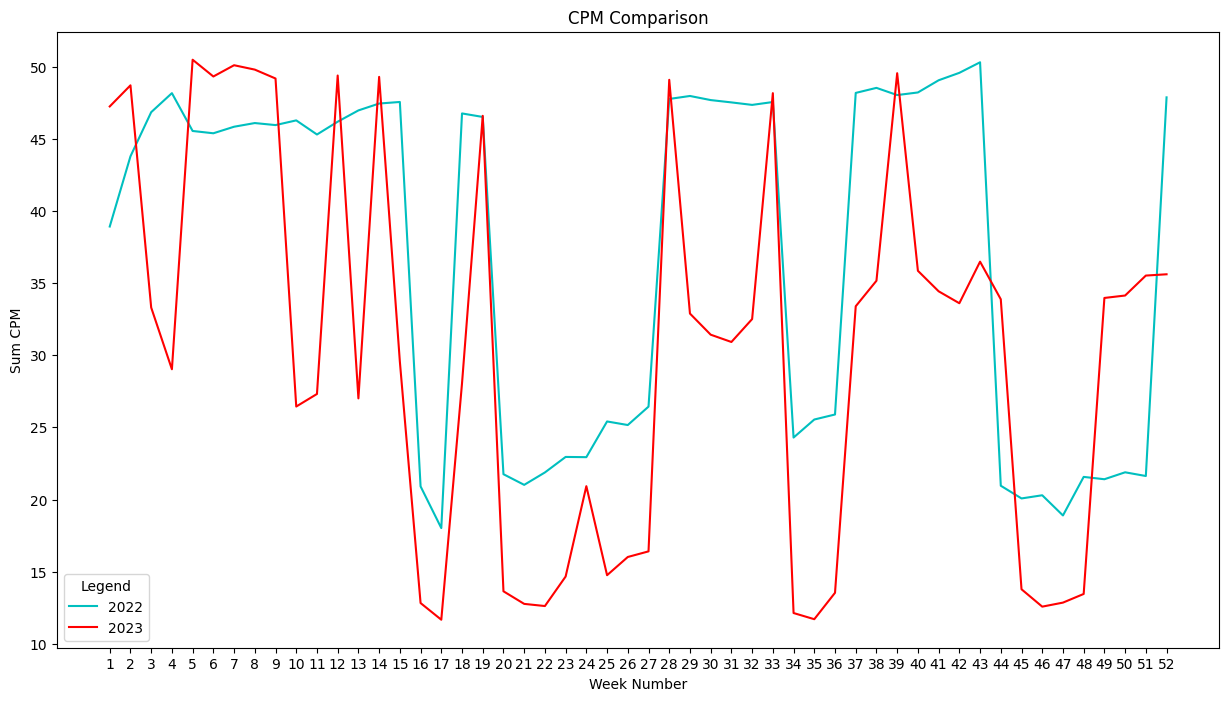

In [52]:
#Graphical comparison

fig, ax1 = plt.subplots(figsize=(15, 8)) 

yr_2022 = yearly_cpm[2022]
yr_2023= yearly_cpm[2023]
week = yearly_cpm['week_num']

plt.plot(week, yr_2022, 'c', label='2022')
plt.plot(week, yr_2023, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Sum CPM')
plt.title('CPM Comparison')

legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


In [53]:
#rolling average

roll_yearly_cpm = cpm_df.pivot(index='week_num', columns='year', values='cpm_rolling_avg')
roll_yearly_cpm = roll_yearly_cpm.reset_index()
roll_yearly_cpm.head()

year,week_num,2022,2023
0,1,NaN,30.265291
1,2,NaN,34.787186
2,3,NaN,36.770090
3,4,NaN,37.959979
4,5,NaN,42.767418


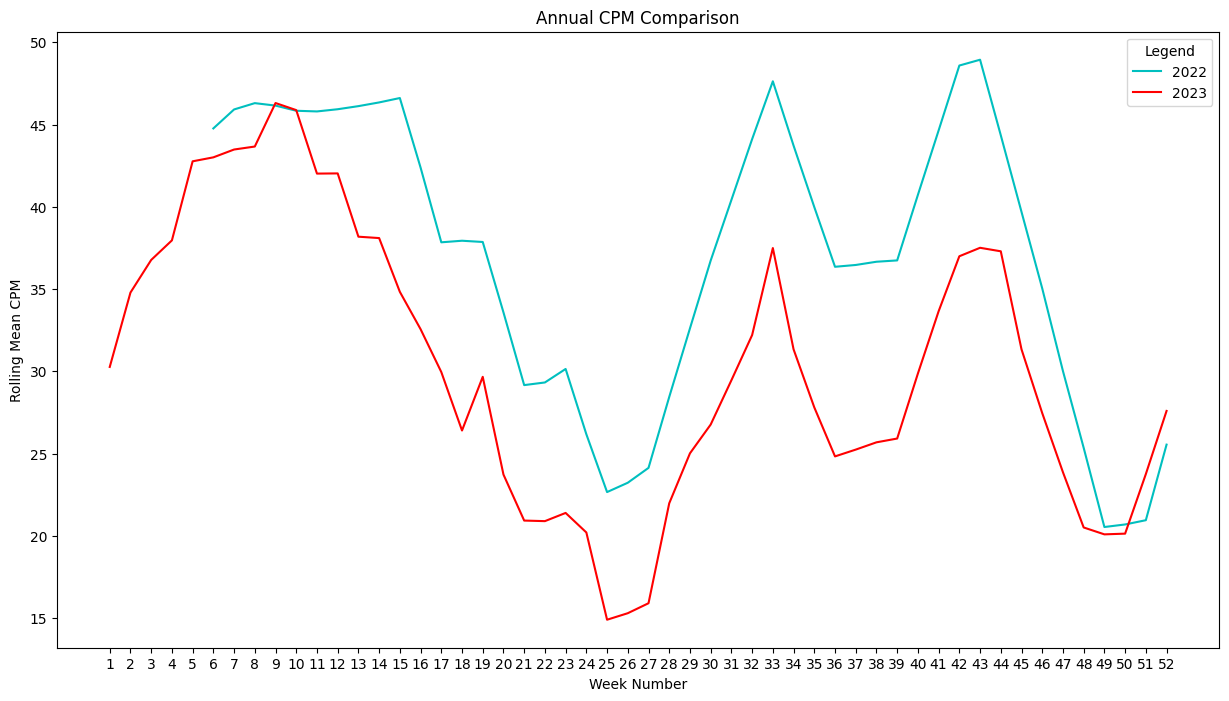

In [54]:

#Rolling avg annual comparison

fig, ax1 = plt.subplots(figsize=(15, 8)) 

yr_2022 = roll_yearly_cpm[2022]
yr_2023= roll_yearly_cpm[2023]
week = roll_yearly_cpm['week_num']

plt.plot(week, yr_2022, 'c', label='2022')
plt.plot(week, yr_2023, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Rolling Mean CPM')
plt.title('Annual CPM Comparison')

legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


### Sales

In [56]:
#Sales

sales_df = clean_df.groupby(['year', 'week_num'])['sales'].sum()
sales_df = pd.DataFrame(sales_df).reset_index()
sales_df.head()

,year,week_num,sales
0,2021,52,7.979141e+09
1,2022,1,2.791222e+10
2,2022,2,2.806228e+10
3,2022,3,3.513597e+10
4,2022,4,3.787666e+10


In [57]:
#yearly sales pivot
yearly_sales = sales_df.pivot(index='week_num', columns='year', values='sales')
yearly_sales = yearly_sales.reset_index()
yearly_sales.head()

year,week_num,2021,2022,2023
0,1,NaN,2.791222e+10,3.860721e+10
1,2,NaN,2.806228e+10,4.406325e+10
2,3,NaN,3.513597e+10,2.868560e+10
3,4,NaN,3.787666e+10,3.318653e+10
4,5,NaN,3.393100e+10,4.494446e+10


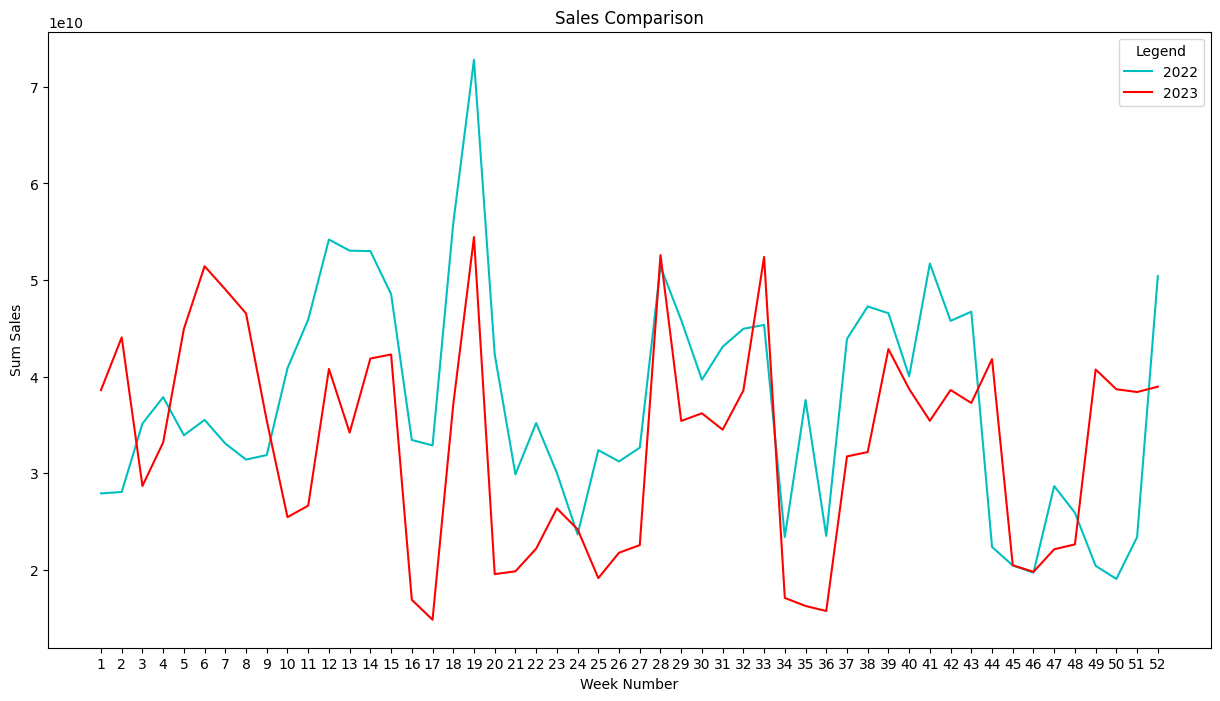

In [58]:

#Sum of sales each week

fig, ax1 = plt.subplots(figsize=(15, 8)) 

yr_2022 = yearly_sales[2022]
yr_2023= yearly_sales[2023]
week = yearly_sales['week_num']


plt.plot(week, yr_2022, 'c', label='2022')
plt.plot(week, yr_2023, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Sum Sales')
plt.title('Sales Comparison')


legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


In [59]:
#6 week rolling average for sales
window_size = 6  

sales_df['sales_rolling_avg'] = sales_df['sales'].rolling(window=window_size).mean()
sales_df.tail()

,year,week_num,sales,sales_rolling_avg
100,2023,48,2.263873e+10,2.735475e+10
101,2023,49,4.074131e+10,2.793288e+10
102,2023,50,3.869526e+10,2.741319e+10
103,2023,51,3.840768e+10,3.040123e+10
104,2023,52,3.896127e+10,3.359580e+10


In [60]:
#rolling avg sales pivot
roll_yearly_sales = sales_df.pivot(index='week_num', columns='year', values='sales_rolling_avg')
roll_yearly_sales = roll_yearly_sales.reset_index()
roll_yearly_sales.head()

year,week_num,2021,2022,2023
0,1,NaN,NaN,2.963155e+10
1,2,NaN,NaN,3.265732e+10
2,3,NaN,NaN,3.403563e+10
3,4,NaN,NaN,3.639037e+10
4,5,NaN,2.848288e+10,3.998318e+10


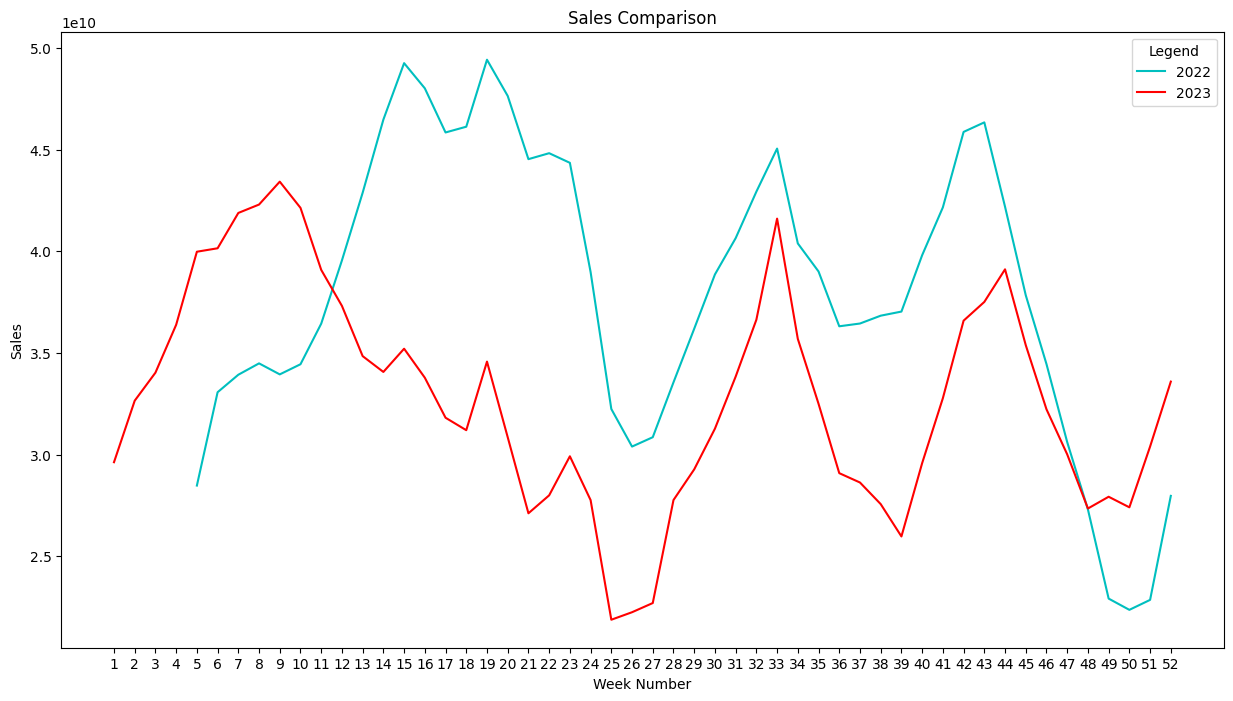

In [61]:
#rolling avg comparison

fig, ax1 = plt.subplots(figsize=(15, 8)) 

yr_2022 = roll_yearly_sales[2022]
yr_2023= roll_yearly_sales[2023]
week = roll_yearly_sales['week_num']

plt.plot(week, yr_2022, 'c', label='2022')
plt.plot(week, yr_2023, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Sales')
plt.title('Sales Comparison')


legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


## Yield Optimization Explorations

In [62]:
#remove any null sales values
clean_df = data_df.dropna(subset=['sales'], how='all')
clean_df.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52


In [67]:
#Insert calculations
clean_df.loc[:, 'roas'] = clean_df['sales'] / clean_df['ad_spend']
clean_df.loc[:, 'roi'] = (clean_df['sales'] - clean_df['ad_spend']) / clean_df['ad_spend']
clean_df.loc[:, 'cpm_ratio'] = clean_df['cpm'] / clean_df['sales']

In [68]:
#Copy data
efficiency_data = clean_df.copy()
efficiency_data.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52,7.000001,6.000001,0.000001
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52,24.999871,23.999871,0.000024
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52,26.999868,25.999868,0.000017
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52,21.999981,20.999981,0.000008
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52,35.999873,34.999873,0.000018


In [69]:
#Create an area field
efficiency_data['area'] =  efficiency_data['taxonomy'].str.split('|', expand=True)[0]
efficiency_data.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52,7.000001,6.000001,0.000001,Appliances
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52,24.999871,23.999871,0.000024,Home Decor
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52,26.999868,25.999868,0.000017,Tools
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52,21.999981,20.999981,0.000008,Tools
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52,35.999873,34.999873,0.000018,Tools


In [70]:
#Calculate margins, handle the 0 values
def calculate_margin(row):
    if row['cpm'] > 0:
        return ((row['sales'] / row['cpm']) / row['sales'] )* 100 
    else:
        return 0  

efficiency_data['margin'] = efficiency_data.apply(calculate_margin, axis=1)

efficiency_data.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52,7.000001,6.000001,0.000001,Appliances,2.777778
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52,24.999871,23.999871,0.000024,Home Decor,4.347826
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52,26.999868,25.999868,0.000017,Tools,2.857143
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52,21.999981,20.999981,0.000008,Tools,2.127660
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52,35.999873,34.999873,0.000018,Tools,3.333333


In [71]:
#Check for any remaining null values
efficiency_data[efficiency_data.isna().any(axis=1)]


,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin


In [72]:
#Explore area roi
efficiency_data.groupby('area')['roi'].mean()

area
Appliances             21.478321
Holiday Decorations    21.931808
Home Decor             21.189699
Outdoors               22.559947
Plumbing               21.602490
Tools                  21.977299
Name: roi, dtype: float64

In [73]:
#Explore ROI data
efficiency_data['roi'].describe()

count    189679.000000
mean         22.093615
std           8.097344
min           0.000000
25%          16.000020
50%          22.000001
75%          27.999996
max          49.000221
Name: roi, dtype: float64

### ROAS

In [74]:
#Creation of ROAS dataframe
roas = efficiency_data.groupby(['year', 'week_num'])['roas'].mean()
roas = pd.DataFrame(roas).reset_index()

roas.head()

,year,week_num,roas
0,2021,52,23.252477
1,2022,1,23.427266
2,2022,2,23.158243
3,2022,3,23.131110
4,2022,4,23.230971


In [75]:
#introduce a rolling roas avg
roas = efficiency_data.groupby(['year', 'week_num'])['roas'].mean()
roas = pd.DataFrame(roas).reset_index()
window_size = 6  

roas['roas_rolling_avg'] = roas['roas'].rolling(window=window_size).mean()
roas = roas.pivot(index='week_num', columns='year', values='roas_rolling_avg')
roas = roas.reset_index()
roas.head()

year,week_num,2021,2022,2023
0,1,NaN,NaN,23.080708
1,2,NaN,NaN,23.085222
2,3,NaN,NaN,23.147394
3,4,NaN,NaN,23.222686
4,5,NaN,23.192195,23.276888


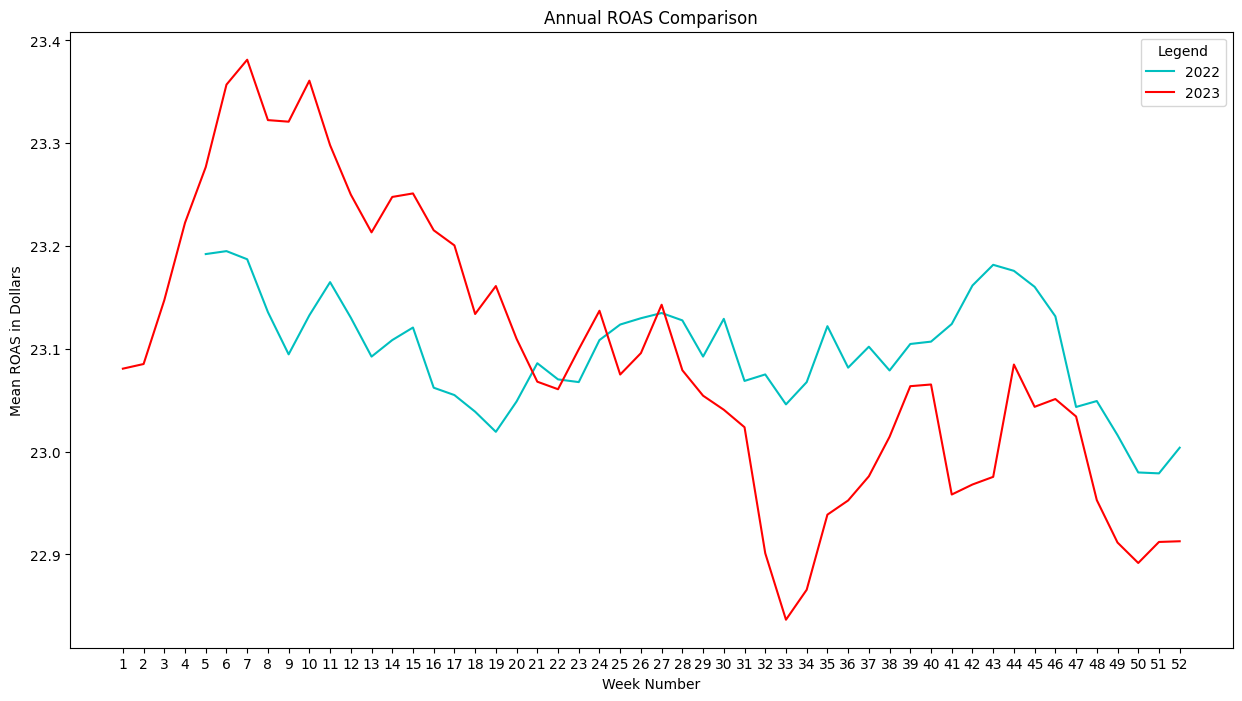

In [76]:

#annual roas comparisons by week
fig, ax1 = plt.subplots(figsize=(15, 8)) 



yr_22 = roas[2022]
yr_23= roas[2023]
week = roas['week_num']


plt.plot(week, yr_22, 'c', label='2022')
plt.plot(week, yr_23, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Mean ROAS in Dollars')
plt.title('Annual ROAS Comparison')


legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


### Dollars Per Impression

In [77]:
#dollars per impression calculation
efficiency_data['dpi'] = efficiency_data['sales']/efficiency_data['ad_impressions']


In [78]:
dpi_data = efficiency_data.groupby(['year', 'week_num'])['dpi'].mean()
dpi_data = pd.DataFrame(dpi_data).reset_index()
dpi_data.head()

,year,week_num,dpi
0,2021,52,895.068770
1,2022,1,910.043056
2,2022,2,1015.885020
3,2022,3,1082.564479
4,2022,4,1118.177655


In [79]:
#rolling average
window_size = 6  

dpi_data['dpi_rolling_avg'] = dpi_data['dpi'].rolling(window=window_size).mean()
dpi_data = dpi_data.pivot(index='week_num', columns='year', values='dpi_rolling_avg')

dpi_data.head()

year,2021,2022,2023
week_num,,,
1,NaN,NaN,697.432601
2,NaN,NaN,805.008767
3,NaN,NaN,853.879600
4,NaN,NaN,883.023703
5,NaN,1010.989277,997.789393


In [80]:
dpi_data = dpi_data.reset_index()
dpi_data.head()

year,week_num,2021,2022,2023
0,1,NaN,NaN,697.432601
1,2,NaN,NaN,805.008767
2,3,NaN,NaN,853.879600
3,4,NaN,NaN,883.023703
4,5,NaN,1010.989277,997.789393


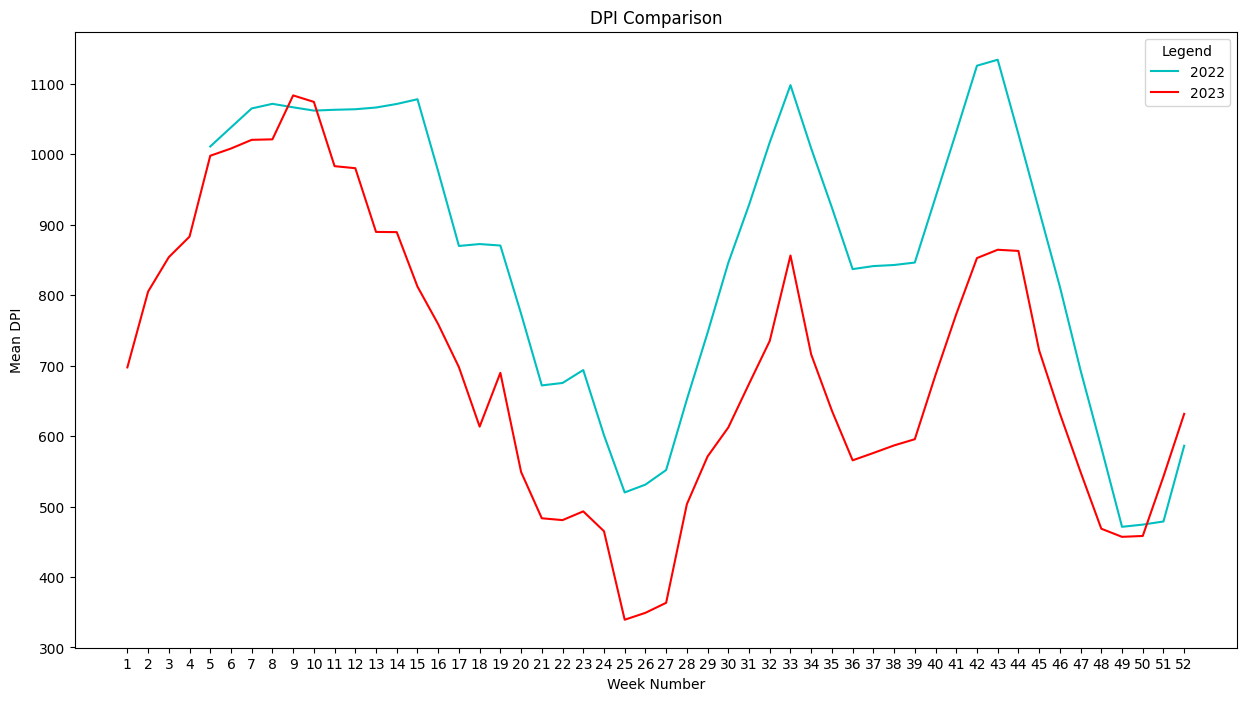

In [82]:
#dpi comparisons
fig, ax1 = plt.subplots(figsize=(15, 8)) 


yr_22 = dpi_data[2022]
yr_23= dpi_data[2023]
week = dpi_data['week_num']


plt.plot(week, yr_22, 'c', label='2022')
plt.plot(week, yr_23, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Mean DPI')
plt.title('DPI Comparison')


legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


In [83]:

# determine the roas by area
area_roas = efficiency_data.groupby(['area','year_month']).agg({
    'roas': 'mean',
    'campaign_id': 'nunique'
}).reset_index()


area_roas = area_roas.sort_values('year_month')
area_roas.head()

,area,year_month,roas,campaign_id
0,Appliances,2021-12,22.363601,107
25,Holiday Decorations,2021-12,23.984139,42
50,Home Decor,2021-12,21.843316,37
125,Tools,2021-12,23.380690,242
100,Plumbing,2021-12,21.837788,137


In [84]:
area_roas = area_roas.pivot(index='area', columns='year_month', values='roas')
area_roas

year_month,2021-12,2022-01,2022-02,2022-03,2022-04,2022-05,2022-06,2022-07,2022-08,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06,2023-07,2023-08,2023-09,2023-10,2023-11,2023-12
area,,,,,,,,,,,,,,,,,,,,,,,,,
Appliances,22.363601,22.153037,22.885094,22.716674,22.815197,22.593909,23.094712,22.580302,22.108061,22.753210,22.475374,22.239712,22.455052,22.633392,22.151973,23.065536,22.854504,22.083659,22.555377,22.557373,22.334284,22.009287,22.253572,21.918000,22.663594
Holiday Decorations,23.984139,23.528241,23.359982,22.363853,22.727403,23.003008,23.250848,23.380022,22.948723,23.320871,23.261968,22.808681,22.885123,23.104834,22.765136,23.382861,22.801058,22.991574,23.120121,22.679491,22.758251,22.636826,22.738051,22.354494,22.367549
Home Decor,21.843316,22.125793,22.195029,22.914448,21.667523,21.752824,21.687672,22.580251,22.967088,21.921235,22.856201,22.014658,21.936721,22.473198,22.284939,22.131685,22.321574,22.207527,22.559953,22.299834,22.066616,21.374301,22.003445,21.939977,22.210296
Outdoors,23.940085,23.674127,23.566678,23.683787,23.441979,23.447704,23.485009,23.476513,23.528903,23.520213,23.658761,23.586597,23.325432,23.872845,23.793321,23.783362,23.703983,23.661017,23.503178,23.446338,23.369813,23.477725,23.569708,23.275822,23.508752
Plumbing,21.837788,23.052858,22.025381,22.438643,22.374010,22.639771,22.410256,22.497786,22.658296,22.588378,22.814741,22.839530,22.773993,22.697705,23.244522,22.776818,22.424927,22.410544,22.311558,22.510223,22.736971,22.537394,22.867132,22.289589,22.512240
Tools,23.380690,22.972858,23.035202,23.115684,23.014719,23.046894,23.223600,23.084616,22.854286,22.942130,22.858997,22.895587,22.834202,23.187181,23.269168,22.782716,23.007727,22.959080,23.080311,22.794944,22.686489,23.066297,22.896575,23.053833,22.822949


### Traffic & Ad Spend

In [85]:
#Explore traffic data
traffic = efficiency_data.copy()
traffic = traffic.groupby(['year', 'week_num'])['traffic'].mean()
traffic = pd.DataFrame(traffic).reset_index()
traffic.head()


,year,week_num,traffic
0,2021,52,11138.454009
1,2022,1,36632.249443
2,2022,2,33584.683185
3,2022,3,36542.474642
4,2022,4,38436.691877


In [86]:
#Rolling avg for traffic
window_size = 6  

traffic['traffic_rolling_avg'] = traffic['traffic'].rolling(window=window_size).mean()
traffic = traffic.pivot(index='week_num', columns='year', values='traffic_rolling_avg')



In [87]:
traffic = traffic.reset_index()
traffic.head()

year,week_num,2021,2022,2023
0,1,NaN,NaN,46088.522128
1,2,NaN,NaN,44858.602585
2,3,NaN,NaN,45459.032642
3,4,NaN,NaN,45936.670982
4,5,NaN,33147.98095,47313.246065


In [88]:
#Explore Ad Spending

ad_spending = efficiency_data.copy()
ad_spending = ad_spending.groupby(['year', 'week_num'])['ad_spend'].mean()
ad_spending = pd.DataFrame(ad_spending).reset_index()
ad_spending.head()

,year,week_num,ad_spend
0,2021,52,198502.918632
1,2022,1,694814.491091
2,2022,2,709526.809020
3,2022,3,834316.056781
4,2022,4,906736.242017


In [89]:
#Rolling avg for ad spend
window_size = 6  

ad_spending = ad_spending.groupby(['year', 'week_num'])['ad_spend'].mean()
ad_spending = pd.DataFrame(ad_spending).reset_index()

ad_spending['ad_spend_rolling_avg'] = ad_spending['ad_spend'].rolling(window=window_size).mean()
ad_spending = ad_spending.pivot(index='week_num', columns='year', values='ad_spend_rolling_avg')
ad_spending = ad_spending.reset_index()
ad_spending.head()


year,week_num,2021,2022,2023
0,1,NaN,NaN,7.321396e+05
1,2,NaN,NaN,8.124698e+05
2,3,NaN,NaN,8.487889e+05
3,4,NaN,NaN,8.923142e+05
4,5,NaN,711225.751142,1.001943e+06


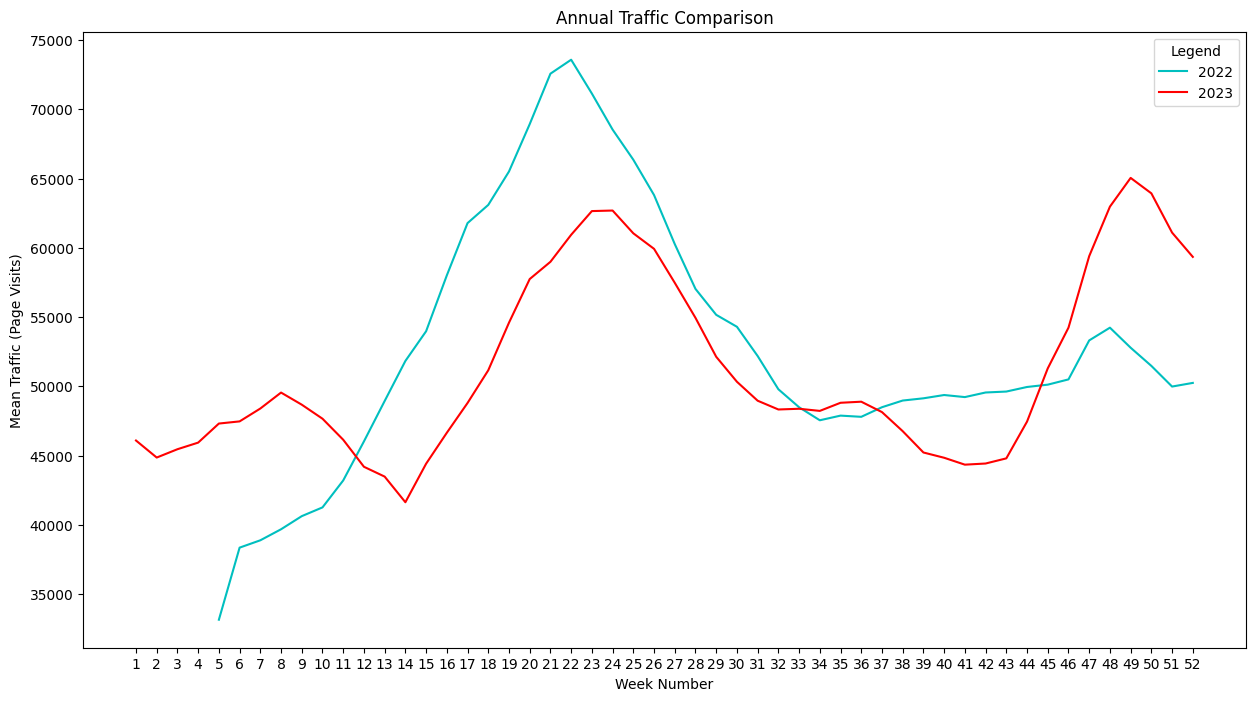

In [90]:
#annual traffic comparisons
fig, ax1 = plt.subplots(figsize=(15, 8)) 


yr_22 = traffic[2022]
yr_23= traffic[2023]
week = traffic['week_num']


plt.plot(week, yr_22, 'c', label='2022')
plt.plot(week, yr_23, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Mean Traffic (Page Visits)')
plt.title('Annual Traffic Comparison')

legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


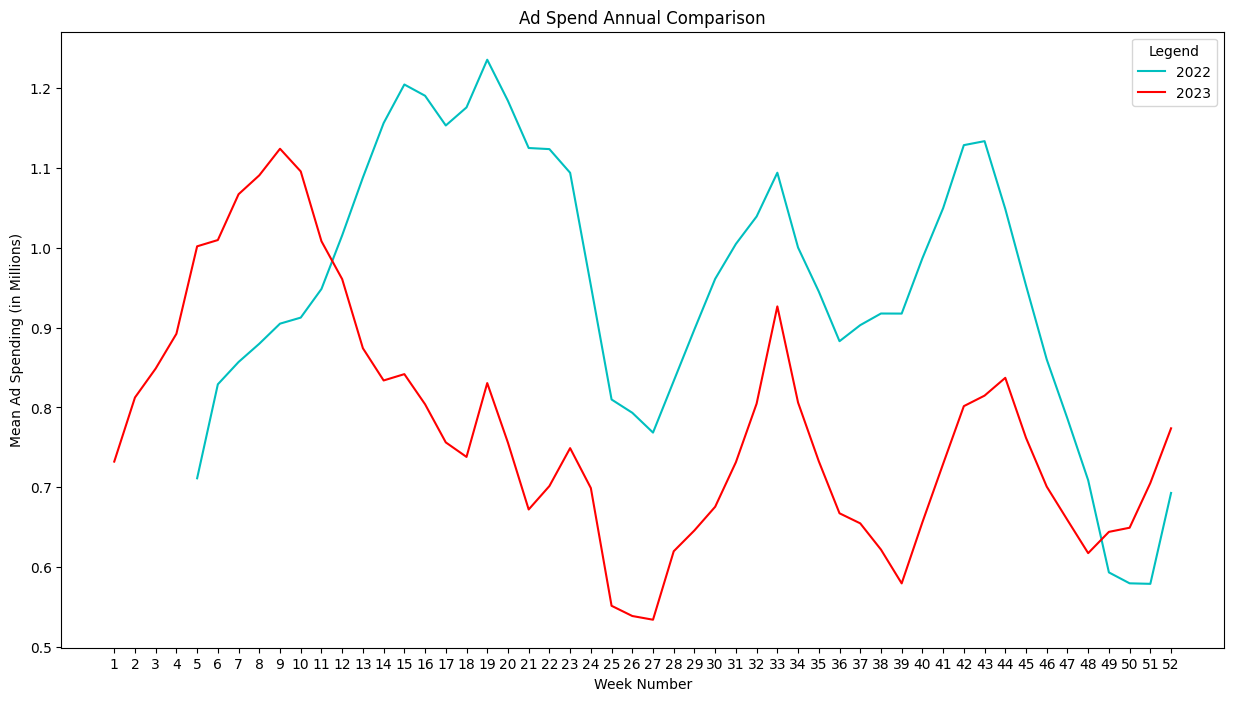

In [91]:
#Annual ad spend comparisons
fig, ax1 = plt.subplots(figsize=(15, 8)) 

yr_22 = ad_spending[2022]/1000000
yr_23= ad_spending[2023]/1000000
week = ad_spending['week_num']

plt.plot(week, yr_22, 'c', label='2022')
plt.plot(week, yr_23, 'r', label='2023')


plt.xlabel('Week Number')
plt.ylabel('Mean Ad Spending (in Millions)')
plt.title('Ad Spend Annual Comparison')


legend_labels = ['2022','2023']
plt.legend(legend_labels, title='Legend');

plt.xticks(week, rotation=360)

plt.show()


In [106]:
efficiency_data['ad_spend_traffic']= efficiency_data['ad_spend']/efficiency_data['traffic']
efficiency_data.describe()

,date,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,week_num,roas,roi,cpm_ratio,margin,dpi,ad_spend_traffic
count,189679,189679.000000,1.896790e+05,1.896790e+05,189679.000000,1.896790e+05,189679.000000,1.896790e+05,189679.000000,189679.000000,189679.0,189679.000000,189679.000000,189679.000000,189679.000000,189679.000000,189679.000000
mean,2023-01-04 06:21:08.243716864,95324.652661,5.149624e+04,2.304647e+04,33.634351,8.490749e+05,9.500677,1.939777e+07,2022.503725,6.594246,27.12984,23.093615,22.093615,0.000119,7.715401,776.438844,15.132347
min,2021-12-27 00:00:00,1.000000,1.000000e+00,1.000000e+00,0.000000,1.200000e+01,4.000000,1.050000e+02,2021.000000,1.000000,1.0,1.000000,0.000000,0.000000,0.000000,0.045594,0.002413
25%,2022-07-04 00:00:00,47827.000000,3.536000e+03,1.549000e+03,17.000000,3.132600e+04,8.000000,6.524455e+05,2022.000000,4.000000,14.0,17.000020,16.000020,0.000003,2.040816,324.729200,7.344541
50%,2023-01-09 00:00:00,95056.000000,1.241300e+04,5.453000e+03,34.000000,1.372150e+05,10.000000,2.924952e+06,2023.000000,7.000000,27.0,23.000001,22.000001,0.000008,2.941176,692.193616,14.627363
75%,2023-07-10 00:00:00,143027.000000,3.875150e+04,1.718950e+04,48.000000,5.217020e+05,11.000000,1.159069e+07,2023.000000,10.000000,40.0,28.999996,27.999996,0.000031,5.555556,1113.648650,21.410691
max,2023-12-25 00:00:00,190494.000000,1.698931e+07,8.252804e+06,747.000000,5.791686e+08,13.000000,1.723965e+10,2023.000000,12.000000,52.0,50.000221,49.000221,0.100694,100.000000,15540.000000,268.920000
std,NaN,54948.678296,2.449867e+05,1.082270e+05,20.389621,5.613942e+06,2.218288,1.368167e+08,0.517562,3.452263,15.058042,8.097344,8.097344,0.001322,15.384818,569.772327,9.801343


### Area CPM

In [109]:
#CPM by each area
area_cpm = efficiency_data[['area', 'year', 'week_num', 'cpm']]
area_cpm = pd.DataFrame(area_cpm).reset_index()
area_cpm.head()

,index,area,year,week_num,cpm
0,0,Appliances,2021,52,36.0
1,37781,Home Decor,2021,52,23.0
2,189430,Tools,2021,52,35.0
3,189115,Tools,2021,52,47.0
4,189010,Tools,2021,52,30.0


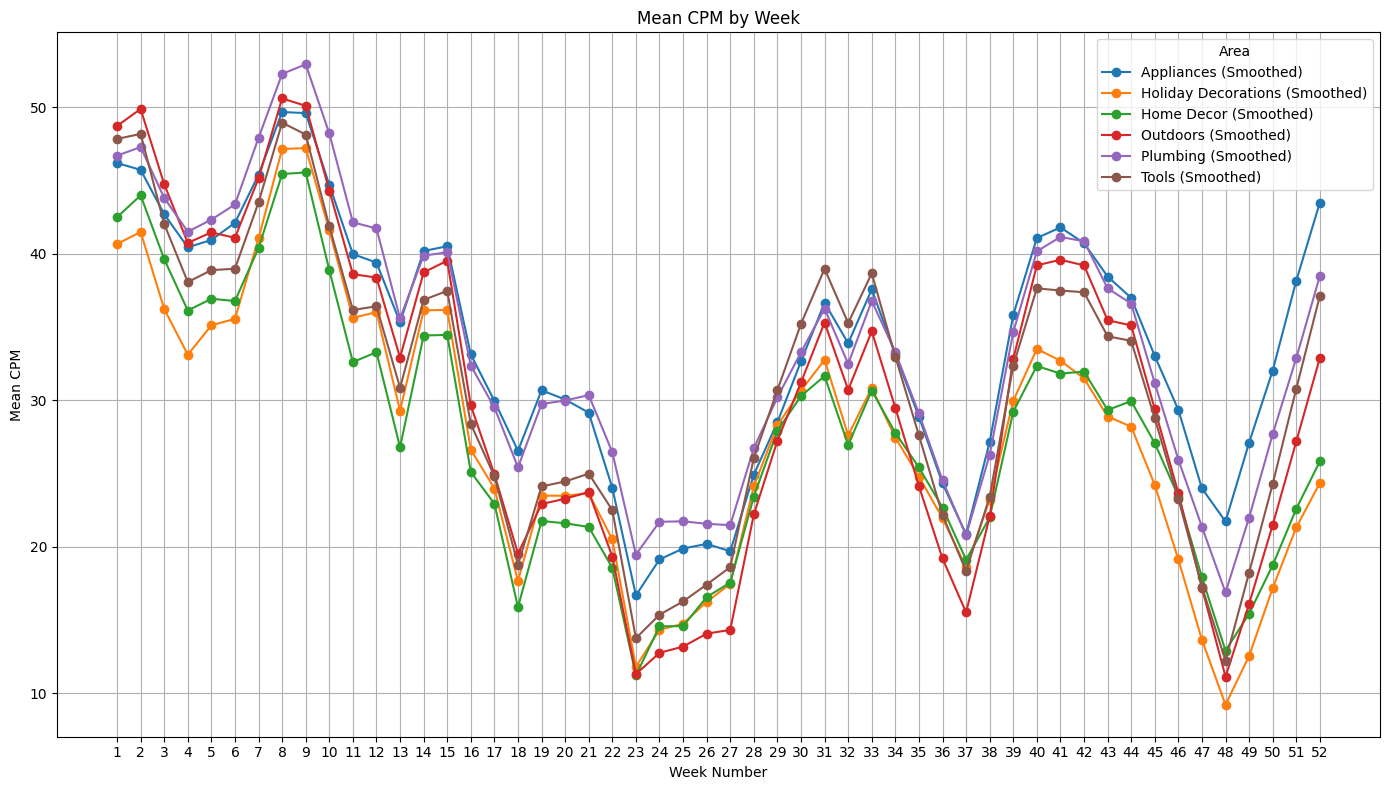

In [125]:
#all area CPMs per week

# filter
all_areas = area_cpm[(area_cpm['year'] == 2023) ]

# weekly variability
variability_by_area = all_areas.groupby(['area', 'week_num'])['cpm'].mean().reset_index()

#rolling
window_size = 4  
variability_by_area['rolling_cpm'] = variability_by_area.groupby('area')['cpm'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='rolling_cpm')
    pivot_tables[area] = pivot_table

# plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area} (Smoothed)')

plt.title('Mean CPM by Week')
plt.xlabel('Week Number')
plt.ylabel('Mean CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


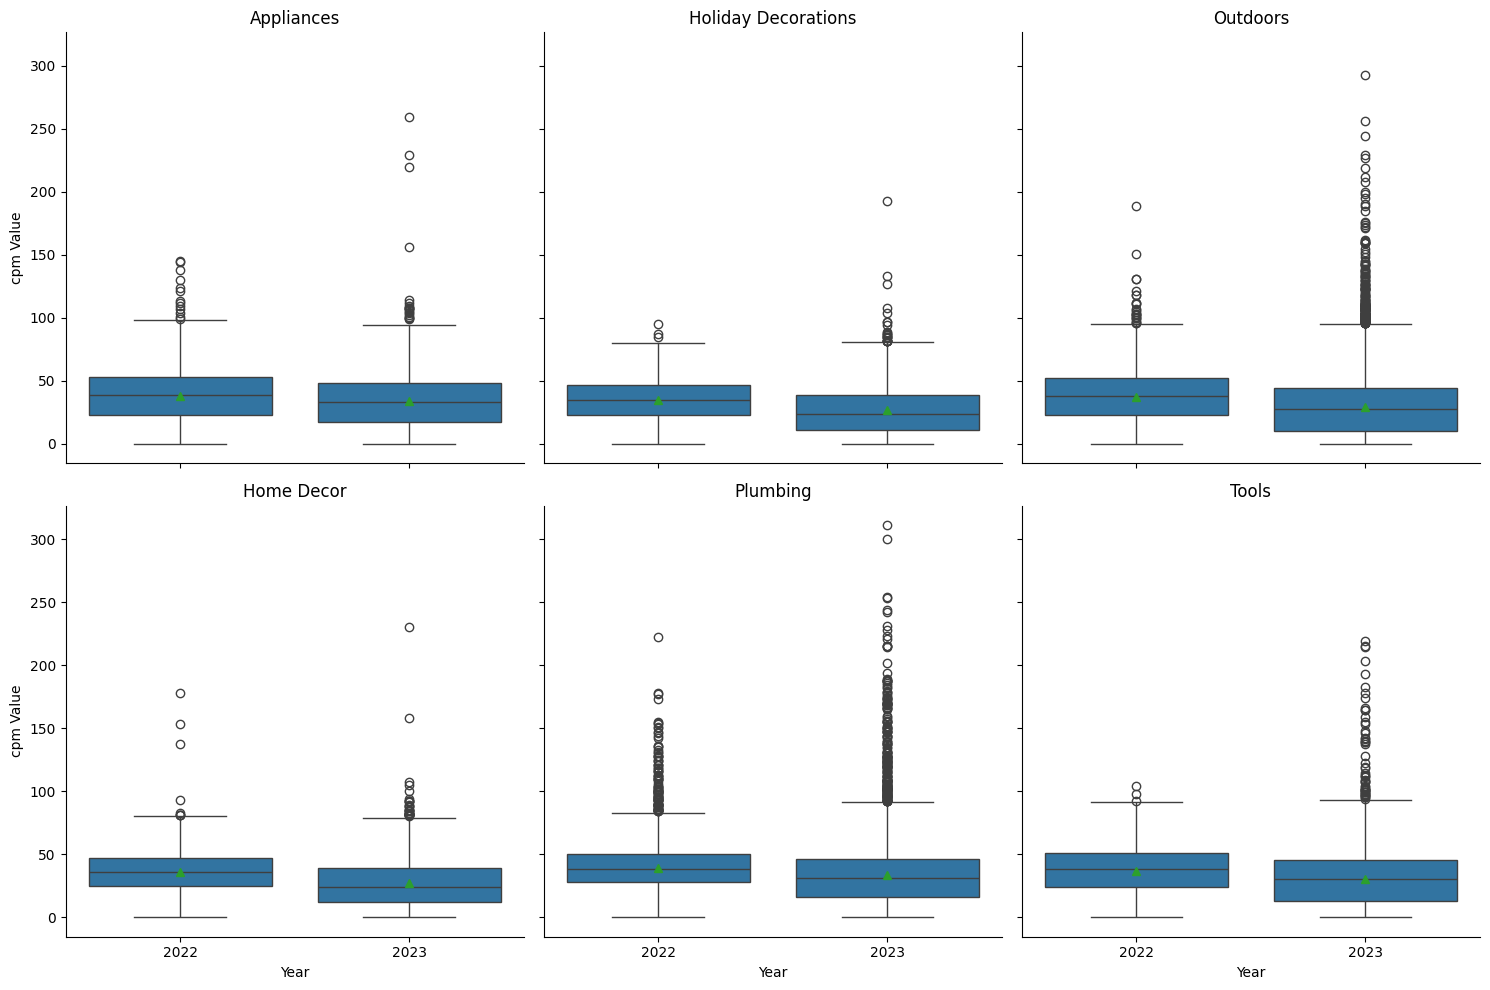

In [110]:

#Closer look at each area cpm data

# results order
area_order = ['Appliances', 'Holiday Decorations',  'Outdoors', 'Home Decor','Plumbing', 'Tools']

# exclude extreme outliers
filtered_data = area_cpm[area_cpm['cpm'] <= 400]

# Categories
year_order = ['2022', '2023']  

# plot
g = sb.FacetGrid(data=filtered_data, col='area', col_order=area_order, height=5, col_wrap=3)
g.map(sb.boxplot, 'year', 'cpm', order=year_order, showmeans=True)

# Titles
titles = ['Appliances', 'Holiday Decorations', 'Outdoors', 'Home Decor', 'Plumbing', 'Tools']

axes = g.axes.flatten()
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("cpm Value")


plt.tight_layout()
plt.show()


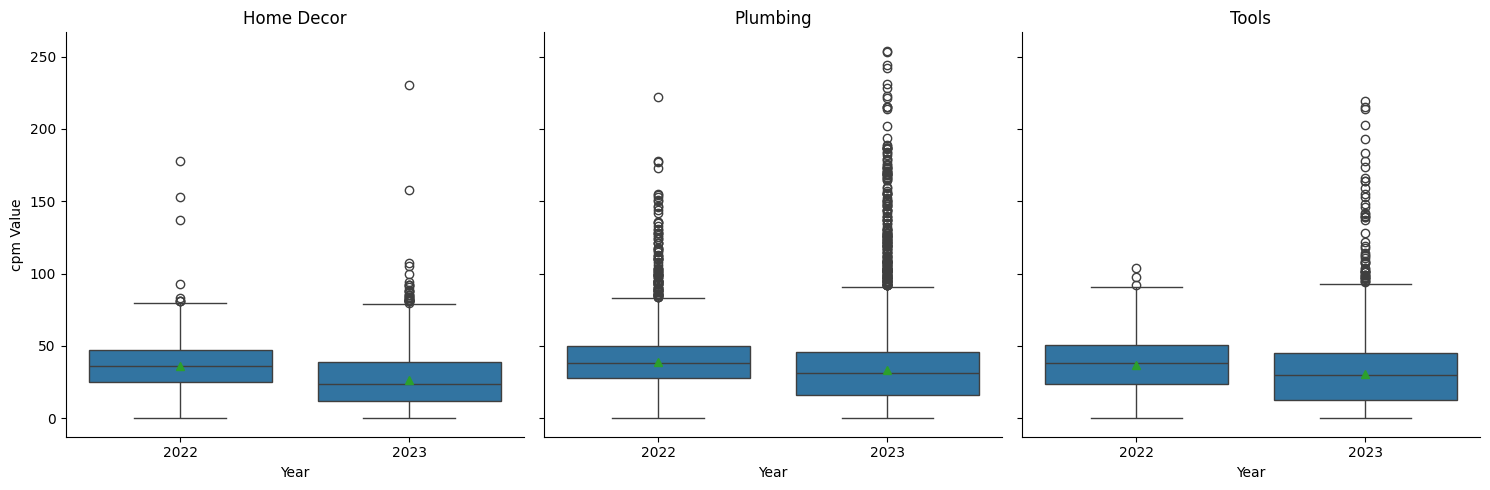

In [111]:
#zoom in on specific areas
area_order = ['Home Decor', 'Plumbing', 'Tools']

#filter the data to just the three areas, exclude 2021, and exclude extreme outliers for closer look
filtered_data = area_cpm[(area_cpm['year'] != 2021) & 
                         (area_cpm['cpm'] < 300) & 
                         ((area_cpm['area'] == 'Home Decor') | 
                          (area_cpm['area'] == 'Plumbing') | 
                          (area_cpm['area'] == 'Tools'))]


year_order = ['2022', '2023'] 

#plot
g = sb.FacetGrid(data=filtered_data, col='area', col_order=area_order, height=5, col_wrap=3)
g.map(sb.boxplot, 'year', 'cpm', order=year_order, showmeans=True)

# Titles
titles = ['Home Decor', 'Plumbing', 'Tools']


axes = g.axes.flatten()
for ax, title in zip(axes, titles):
    ax.set_title(title)
    ax.set_xlabel("Year")
    ax.set_ylabel("cpm Value")

plt.tight_layout()
plt.show()


### CPM Variability

In [112]:
#Closer look at the variability within the Plumbing area

# filter
plumbing_data = efficiency_data[efficiency_data['area'] == 'Plumbing']

# calculate standard deviation weekly
weekly_variability = plumbing_data.groupby('week_num')['cpm'].std().reset_index()
weekly_variability = weekly_variability.rename(columns={'cpm': 'std_dev_cpm'})
weekly_max_variability_week = weekly_variability.loc[weekly_variability['std_dev_cpm'].idxmax()]

# Monthly
monthly_variability = plumbing_data.groupby('month')['cpm'].std().reset_index()
monthly_variability = monthly_variability.rename(columns={'cpm': 'std_dev_cpm'})
monthly_max_variability_month = monthly_variability.loc[monthly_variability['std_dev_cpm'].idxmax()]


print("Week with highest CPM variability:")
print(weekly_max_variability_week)

print("\nMonth with highest CPM variability:")
print(monthly_max_variability_month)


Week with highest CPM variability:
week_num            10.0
std_dev_cpm    28.936771
Name: 9, dtype: Float64

Month with highest CPM variability:
month           7.000000
std_dev_cpm    23.063988
Name: 6, dtype: float64


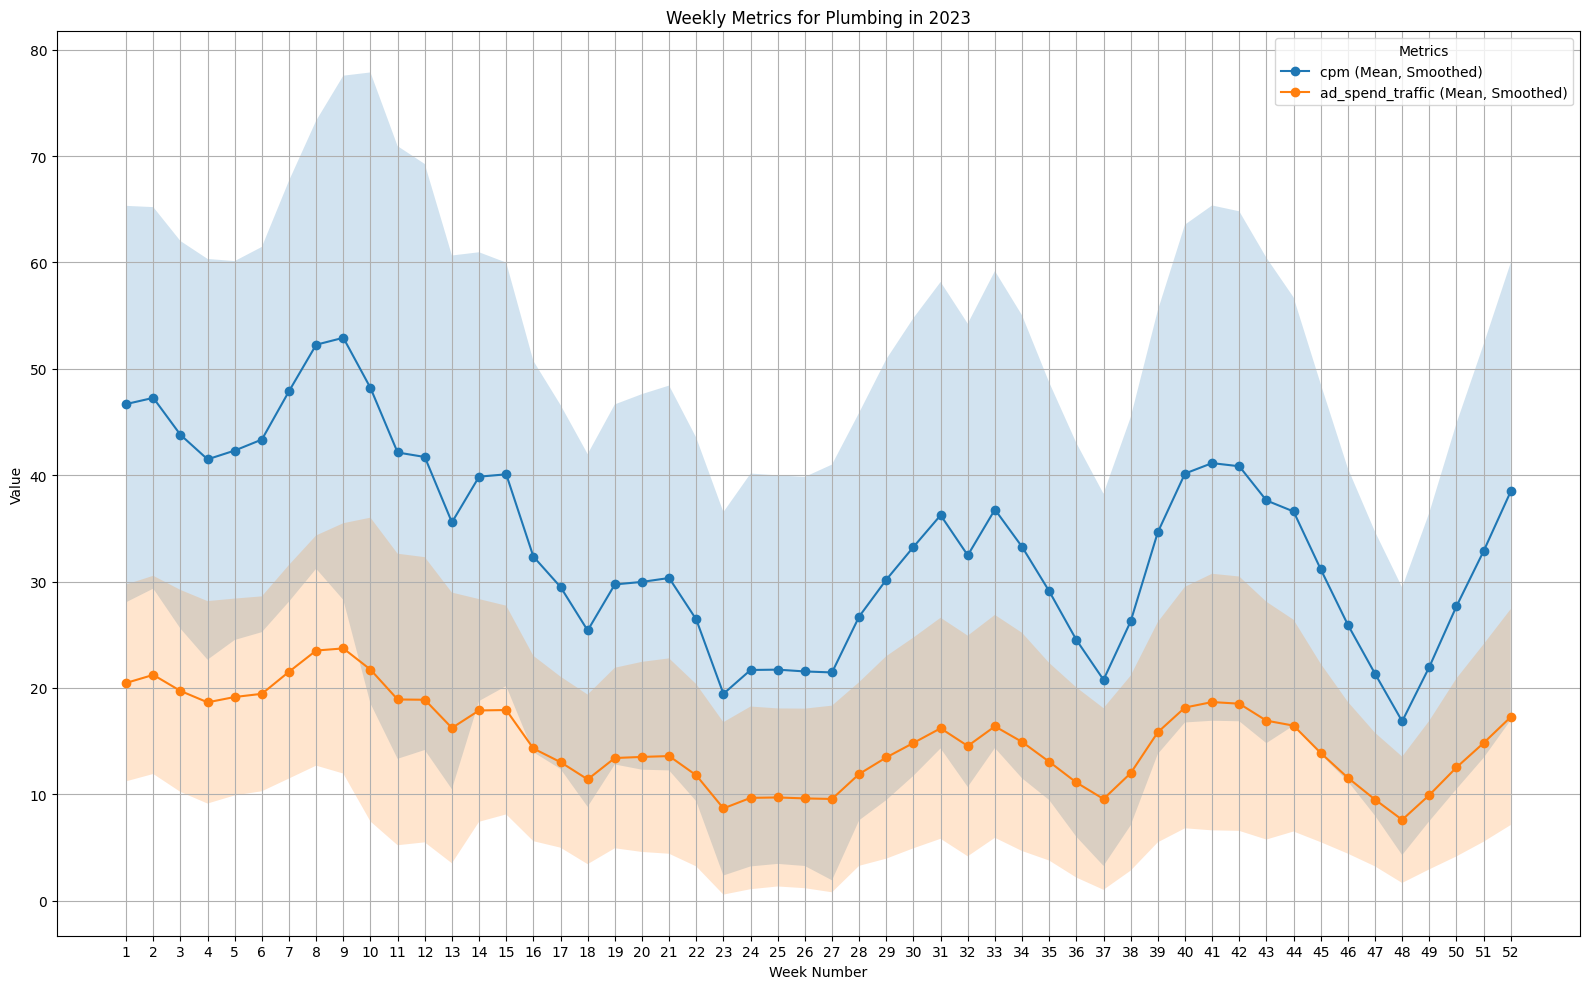

In [114]:

#visual of plumbing variability

# Filter
plumbing_2023 = efficiency_data[(efficiency_data['year'] == 2023) & (efficiency_data['area'] == 'Plumbing')]

# weekly stats
metrics = ['cpm', 'ad_spend_traffic']
metrics_stats = {}
for metric in metrics:
    metric_data = plumbing_2023.groupby('week_num')[metric].agg(['mean', 'std']).reset_index()
    metric_data = metric_data.rename(columns={'mean': f'{metric}_mean', 'std': f'{metric}_std'})
    
    # rolling avgs
    window_size = 4  
    metric_data[f'{metric}_rolling_mean'] = metric_data[f'{metric}_mean'].rolling(window=window_size, min_periods=1).mean()
    metric_data[f'{metric}_rolling_std'] = metric_data[f'{metric}_std'].rolling(window=window_size, min_periods=1).mean()
    
    metrics_stats[metric] = metric_data

#plot
plt.figure(figsize=(16, 10))
for metric, data in metrics_stats.items():

    
    plt.plot(data['week_num'], data[f'{metric}_rolling_mean'], marker='o', label=f'{metric} (Mean, Smoothed)')
    plt.fill_between(data['week_num'], 
                     data[f'{metric}_rolling_mean'] - data[f'{metric}_rolling_std'],
                     data[f'{metric}_rolling_mean'] + data[f'{metric}_rolling_std'],
                     alpha=0.2)  

plt.title('Weekly Metrics for Plumbing in 2023')
plt.xlabel('Week Number')
plt.ylabel('Value')
plt.legend(title='Metrics')
plt.grid(True)
plt.xticks(ticks=data['week_num']) 
plt.tight_layout()
plt.show()


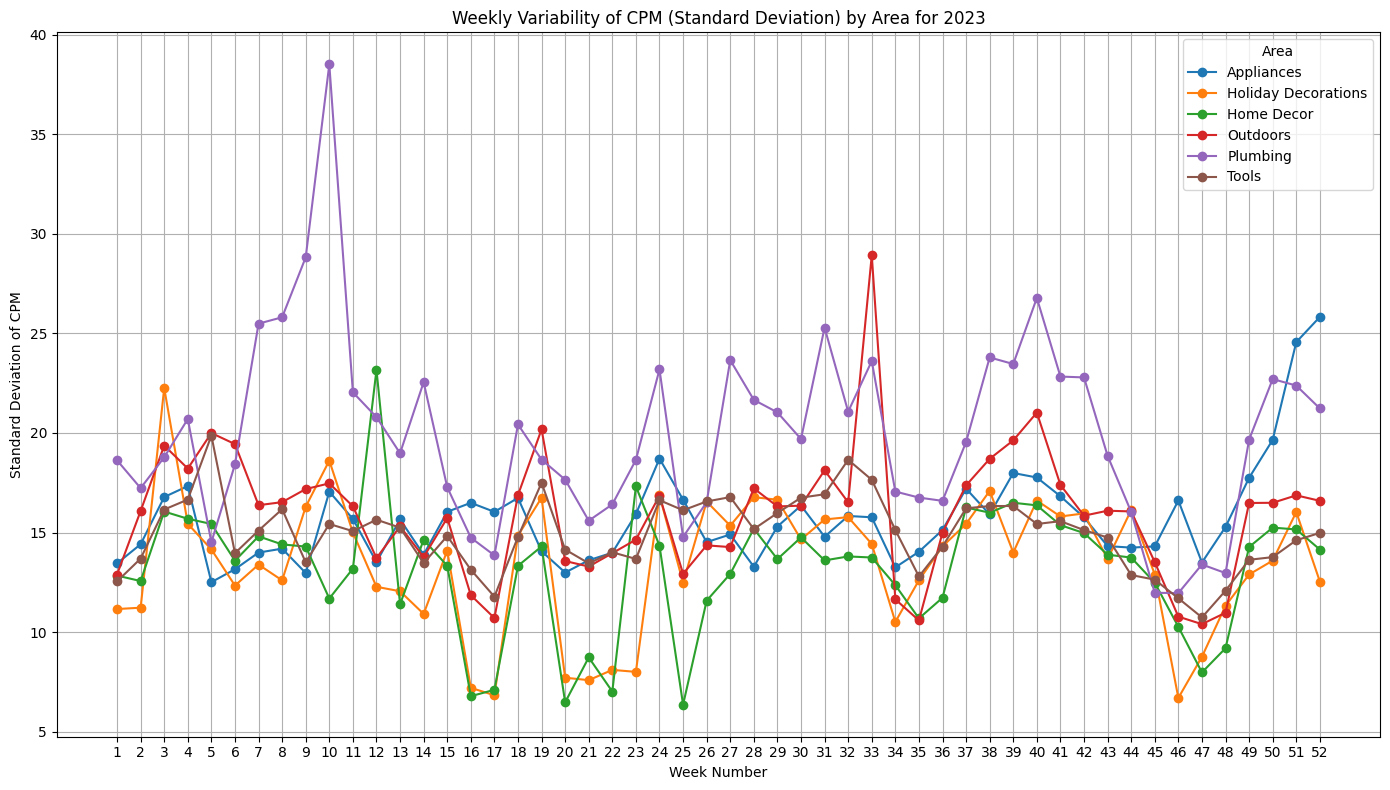

In [115]:
#weekly variability across all areas

data_2023 = area_cpm[area_cpm['year'] == 2023]

# Weekly variability
variability_by_area = data_2023.groupby(['area', 'week_num'])['cpm'].std().reset_index()
variability_by_area = variability_by_area.rename(columns={'cpm': 'std_dev_cpm'})

#Pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='std_dev_cpm')
    pivot_tables[area] = pivot_table

# Plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=area)

plt.title('Weekly Variability of CPM (Standard Deviation) by Area for 2023')
plt.xlabel('Week Number')
plt.ylabel('Standard Deviation of CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)
plt.tight_layout()
plt.show()


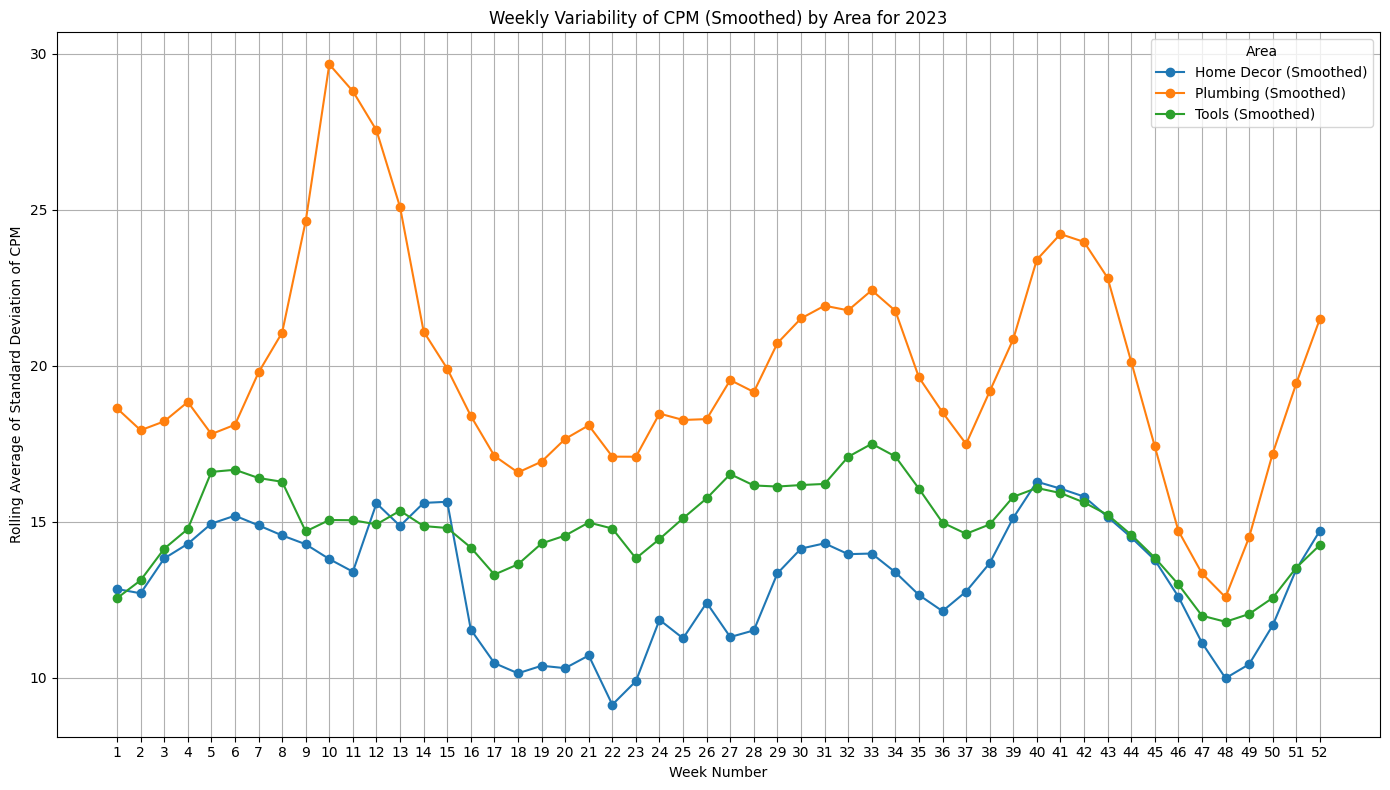

In [116]:
#Group B areas only

#Filter for group B areas
group_b = area_cpm[(area_cpm['year'] == 2023) & 
                     ((area_cpm['area'] == 'Home Decor') | 
                      (area_cpm['area'] == 'Plumbing') | 
                      (area_cpm['area'] == 'Tools'))]

# variability
variability_by_area = group_b.groupby(['area', 'week_num'])['cpm'].std().reset_index()
variability_by_area = variability_by_area.rename(columns={'cpm': 'std_dev_cpm'})

# rolling average
window_size = 4  
variability_by_area['rolling_std_dev_cpm'] = variability_by_area.groupby('area')['std_dev_cpm'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# Pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='rolling_std_dev_cpm')
    pivot_tables[area] = pivot_table

# Plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area} (Smoothed)')

plt.title('Weekly Variability of CPM (Smoothed) by Area for 2023')
plt.xlabel('Week Number')
plt.ylabel('Rolling Average of Standard Deviation of CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


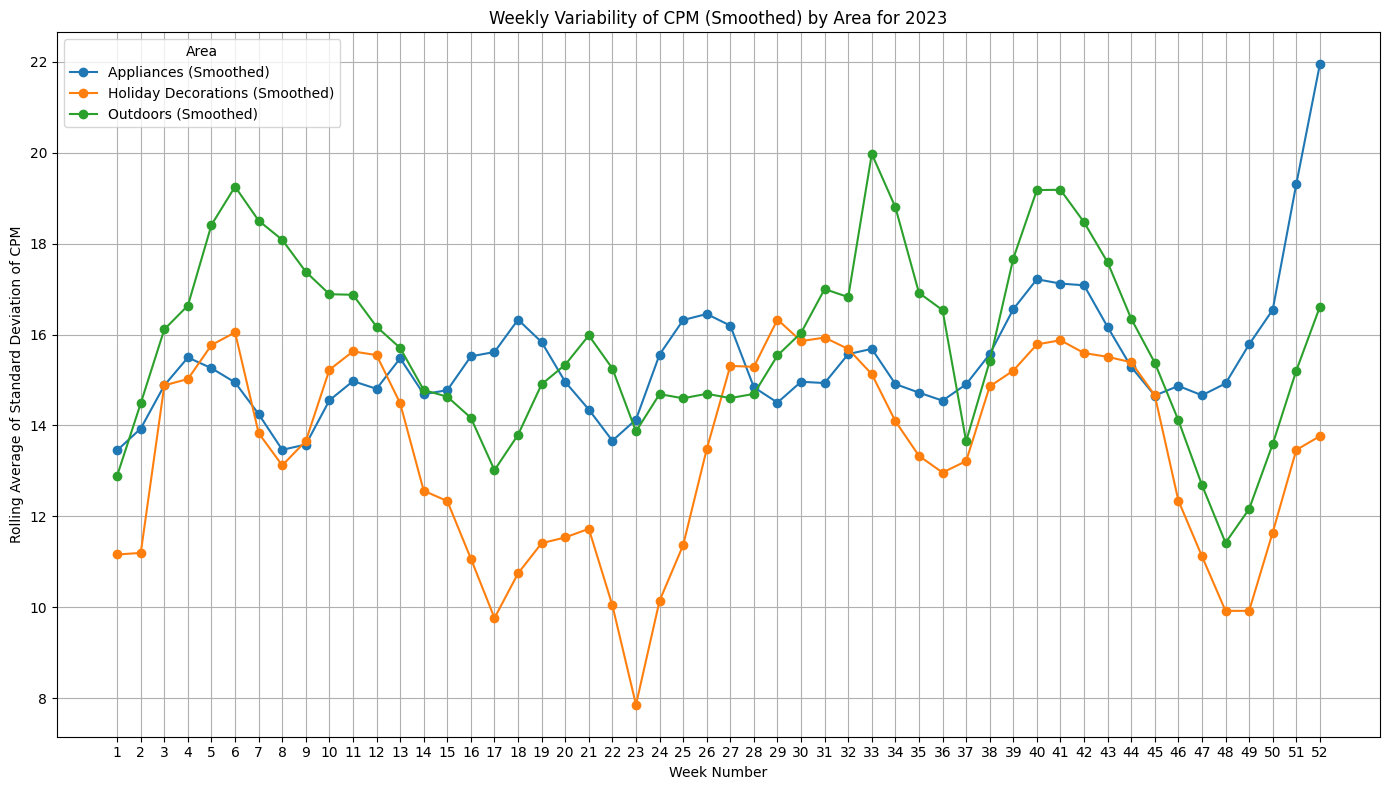

In [120]:
#Group A variability

#filter
data_2023 = area_cpm[(area_cpm['year'] == 2023) & 
                     ((area_cpm['area'] == 'Appliances') | 
                      (area_cpm['area'] == 'Outdoors') | 
                      (area_cpm['area'] == 'Holiday Decorations'))]

# Weekly
variability_by_area = data_2023.groupby(['area', 'week_num'])['cpm'].std().reset_index()
variability_by_area = variability_by_area.rename(columns={'cpm': 'std_dev_cpm'})

# rolling
window_size = 4 
variability_by_area['rolling_std_dev_cpm'] = variability_by_area.groupby('area')['std_dev_cpm'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='rolling_std_dev_cpm')
    pivot_tables[area] = pivot_table

# plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area} (Smoothed)')

plt.title('Weekly Variability of CPM (Smoothed) by Area for 2023')
plt.xlabel('Week Number')
plt.ylabel('Rolling Average of Standard Deviation of CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


In [121]:
efficiency_data.groupby('area')['ad_impressions'].mean()

area
Appliances             36962.342398
Holiday Decorations    31159.356459
Home Decor             13214.658056
Outdoors               24545.251727
Plumbing               19472.392471
Tools                  17025.980670
Name: ad_impressions, dtype: float64

### AREA Traffic

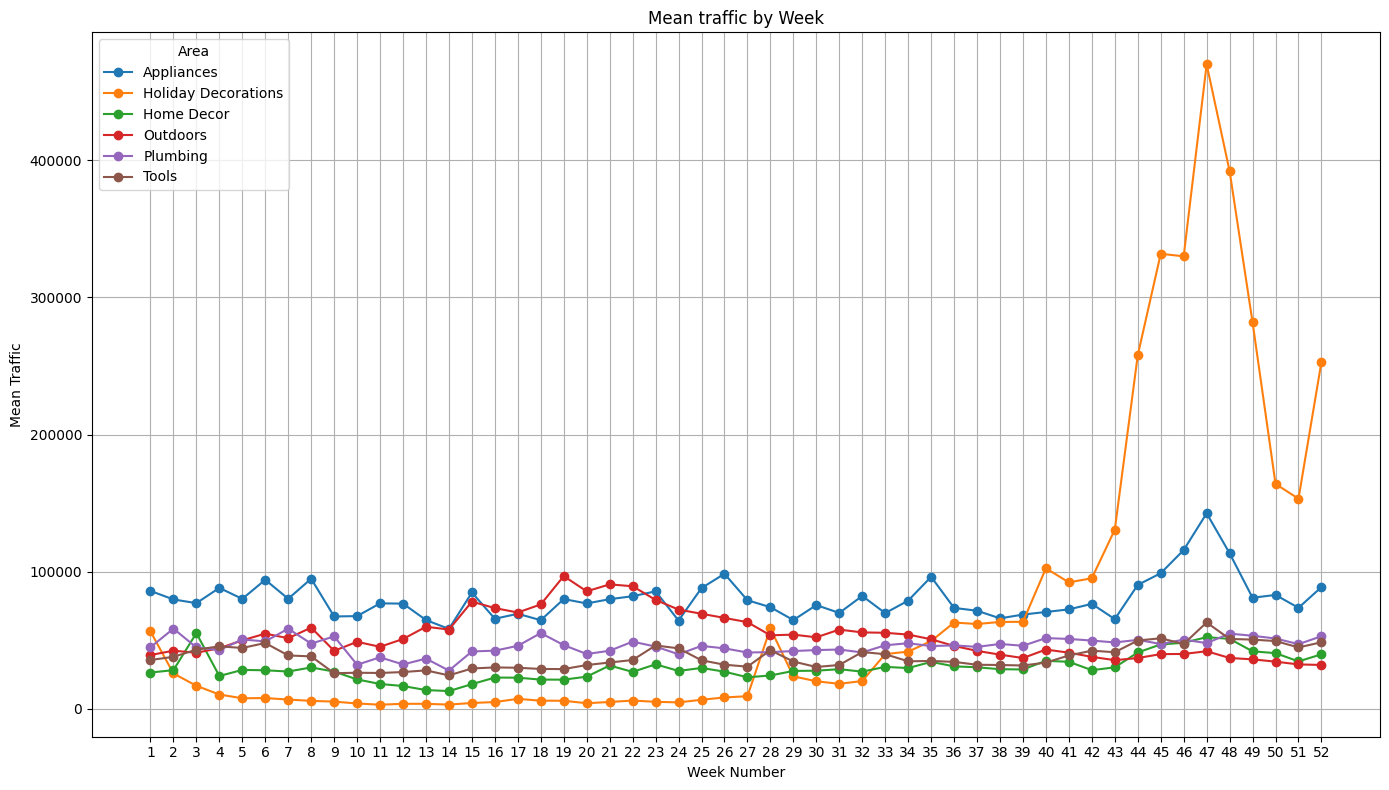

In [126]:
#Overall traffic 

#filter
data_2023 = efficiency_data[(efficiency_data['year'] == 2023)]


# variability in traffic
variability_by_area = data_2023.groupby(['area', 'week_num'])['traffic'].mean().reset_index()


# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='traffic')
    pivot_tables[area] = pivot_table

#plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area}')

plt.title('Mean traffic by Week')
plt.xlabel('Week Number')
plt.ylabel('Mean Traffic')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


### Dynamic Pricing Function

In [122]:
base_price = efficiency_data['cpm'].mean()
base_price

33.6343506661254

In [123]:

# Calculate traffic percentiles
high_traffic_threshold = np.percentile(efficiency_data['traffic'], 80)  # 80th percentile
low_traffic_threshold = np.percentile(efficiency_data['traffic'], 20)   # 20th percentile

print(f"High Traffic Threshold: {high_traffic_threshold}")
print(f"Low Traffic Threshold: {low_traffic_threshold}")


High Traffic Threshold: 50711.399999999994
Low Traffic Threshold: 2575.0


In [124]:
def dynamic_pricing_based_on_traffic(current_traffic, base_price):
    if current_traffic > high_traffic_threshold:
        price = base_price * 1.2  # 20% increase
    elif current_traffic < low_traffic_threshold:
        price = base_price * 0.8  # 20% decrease
    else:
        price = base_price  # Maintain base price during normal traffic

    return price


# Apply dynamic pricing based on traffic as a proxy for demand
efficiency_data['dynamic_cpm'] = efficiency_data['traffic'].apply(lambda x: dynamic_pricing_based_on_traffic(x, base_price))

efficiency_data.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin,dpi,ad_spend_traffic,dynamic_cpm
0,2021-12-27,Appliances,789.0,186565.0,111939.0,36.0,3994543.0,7.0,27961803.0,2021,12,2021-12,52,7.000001,6.000001,0.000001,Appliances,2.777778,249.795004,21.410999,40.361221
37781,2021-12-27,Home Decor|Home Accents,747.0,2944.0,1678.0,23.0,38762.0,9.0,969045.0,2021,12,2021-12,52,24.999871,23.999871,0.000024,Home Decor,4.347826,577.500000,13.166440,33.634351
189430,2021-12-27,Tools|Hand Tools|Knives & Blades|Knives,1280.0,4373.0,2143.0,35.0,75734.0,11.0,2044808.0,2021,12,2021-12,52,26.999868,25.999868,0.000017,Tools,2.857143,954.180121,17.318546,33.634351
189115,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Wrench Sets,1282.0,12967.0,5446.0,47.0,258304.0,11.0,5682683.0,2021,12,2021-12,52,21.999981,20.999981,0.000008,Tools,2.127660,1043.459971,19.920105,33.634351
189010,2021-12-27,Tools|Hand Tools|Hand Tool Sets|Socket Adapter...,1278.0,3874.0,1550.0,30.0,47076.0,9.0,1694730.0,2021,12,2021-12,52,35.999873,34.999873,0.000018,Tools,3.333333,1093.374194,12.151781,33.634351


### Holiday Decorations Test

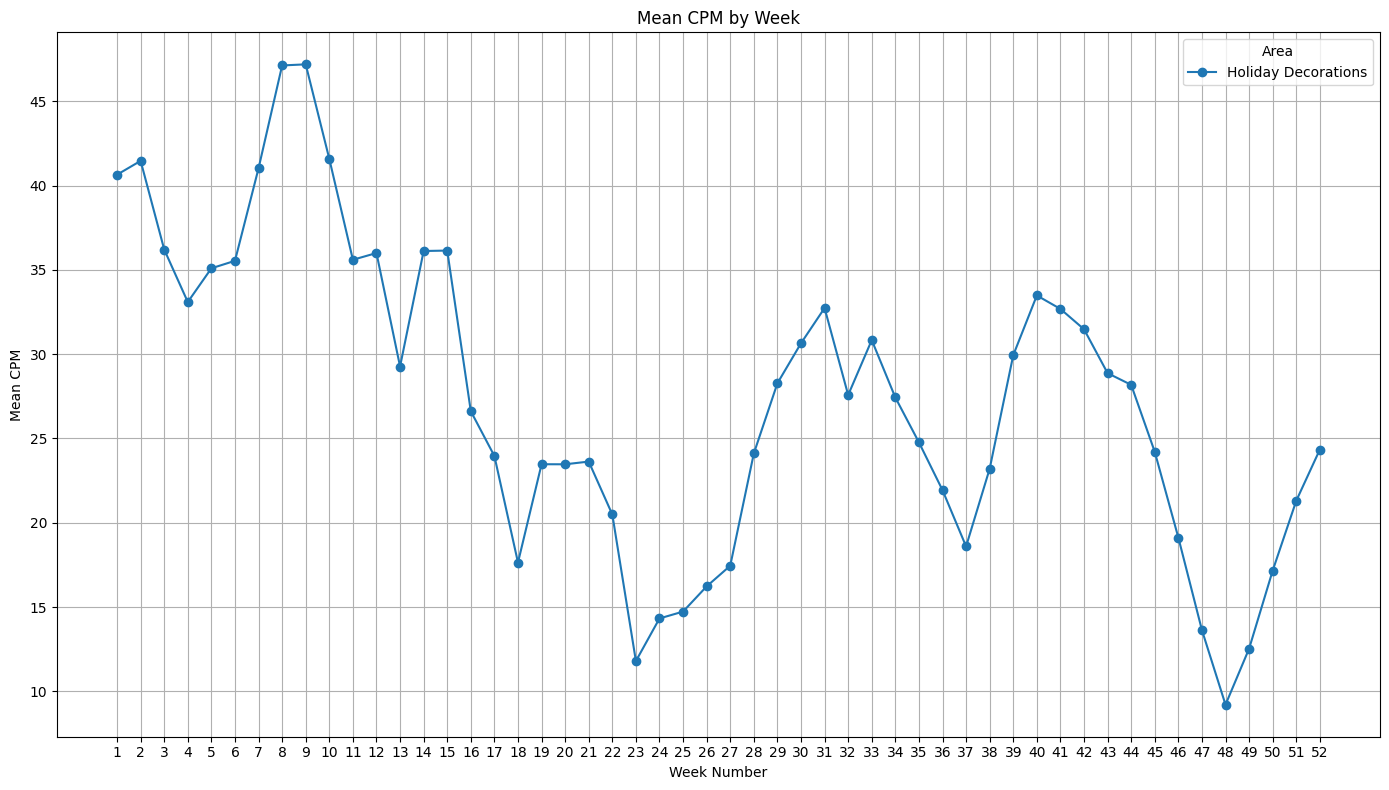

In [130]:
#Holiday data before dynamic pricing

#filter data
holiday_data = efficiency_data[(efficiency_data['year'] == 2023) &(efficiency_data['area'] == 'Holiday Decorations')]


# variability
variability_by_area = holiday_data.groupby(['area', 'week_num'])['cpm'].mean().reset_index()


# rolling avgs
window_size = 4  
variability_by_area['rolling_cpm'] = variability_by_area.groupby('area')['cpm'].transform(lambda x: x.rolling(window=window_size, min_periods=1).mean())

# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='rolling_cpm')
    pivot_tables[area] = pivot_table

# plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area}')

plt.title('Mean CPM by Week')
plt.xlabel('Week Number')
plt.ylabel('Mean CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


In [131]:
#Apply dynamic pricing to holiday data

# Calculate traffic percentiles
high_traffic_threshold = np.percentile(holiday_data['traffic'], 80)  # 80th percentile
low_traffic_threshold = np.percentile(holiday_data['traffic'], 20)   # 20th percentile

print(f"High Traffic Threshold: {high_traffic_threshold}")
print(f"Low Traffic Threshold: {low_traffic_threshold}")

base_price = holiday_data['cpm'].mean()

#funcion to calculate pricing based on traffic
def dynamic_pricing_based_on_traffic(current_traffic, base_price):
   
    if current_traffic > high_traffic_threshold:
        
        scaling_factor = 1 + 0.02 * ((current_traffic - high_traffic_threshold) / (holiday_data['traffic'].max() - high_traffic_threshold)) ** 2
        price = base_price * min(scaling_factor, 2.0)  
    elif current_traffic < low_traffic_threshold:
       
        scaling_factor = 1 - 0.02 * ((low_traffic_threshold - current_traffic) / low_traffic_threshold) ** 2
        price = base_price * max(scaling_factor, 0.5) 
    else:
        price = base_price  

    return price

# Apply the dynamic pricing function
holiday_data['dynamic_cpm'] = holiday_data['traffic'].apply(lambda x: dynamic_pricing_based_on_traffic(x, base_price))
holiday_data.head()

High Traffic Threshold: 29290.400000000074
Low Traffic Threshold: 1058.8000000000004


,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin,dpi,ad_spend_traffic,dynamic_cpm
22056,2023-01-02,Holiday Decorations|Christmas Decorations|Chri...,94349.0,2113.0,1014.0,38.0,38066.0,11.0,532921.0,2023,1,2023-01,1,13.999921,12.999921,0.000071,Holiday Decorations,2.631579,525.563116,18.015144,26.568095
22581,2023-01-02,Holiday Decorations|Christmas Decorations|Chri...,94345.0,6199.0,1922.0,49.0,94520.0,8.0,2646552.0,2023,1,2023-01,1,27.999915,26.999915,0.000019,Holiday Decorations,2.040816,1376.978148,15.247621,26.568095
22476,2023-01-02,Holiday Decorations|Christmas Decorations|Chri...,94347.0,63493.0,28572.0,34.0,964019.0,8.0,23136463.0,2023,1,2023-01,1,24.000007,23.000007,0.000001,Holiday Decorations,2.941176,809.760010,15.183075,26.568102
22371,2023-01-02,Holiday Decorations|Christmas Decorations|Chri...,94346.0,6034.0,3620.0,52.0,189868.0,12.0,6075762.0,2023,1,2023-01,1,31.999926,30.999926,0.000009,Holiday Decorations,1.923077,1678.387293,31.466357,26.568095
22266,2023-01-02,Holiday Decorations|Christmas Decorations|Chri...,94348.0,65693.0,32847.0,23.0,749897.0,11.0,15747837.0,2023,1,2023-01,1,21.000000,20.000000,0.000001,Holiday Decorations,4.347826,479.429994,11.415174,26.568102


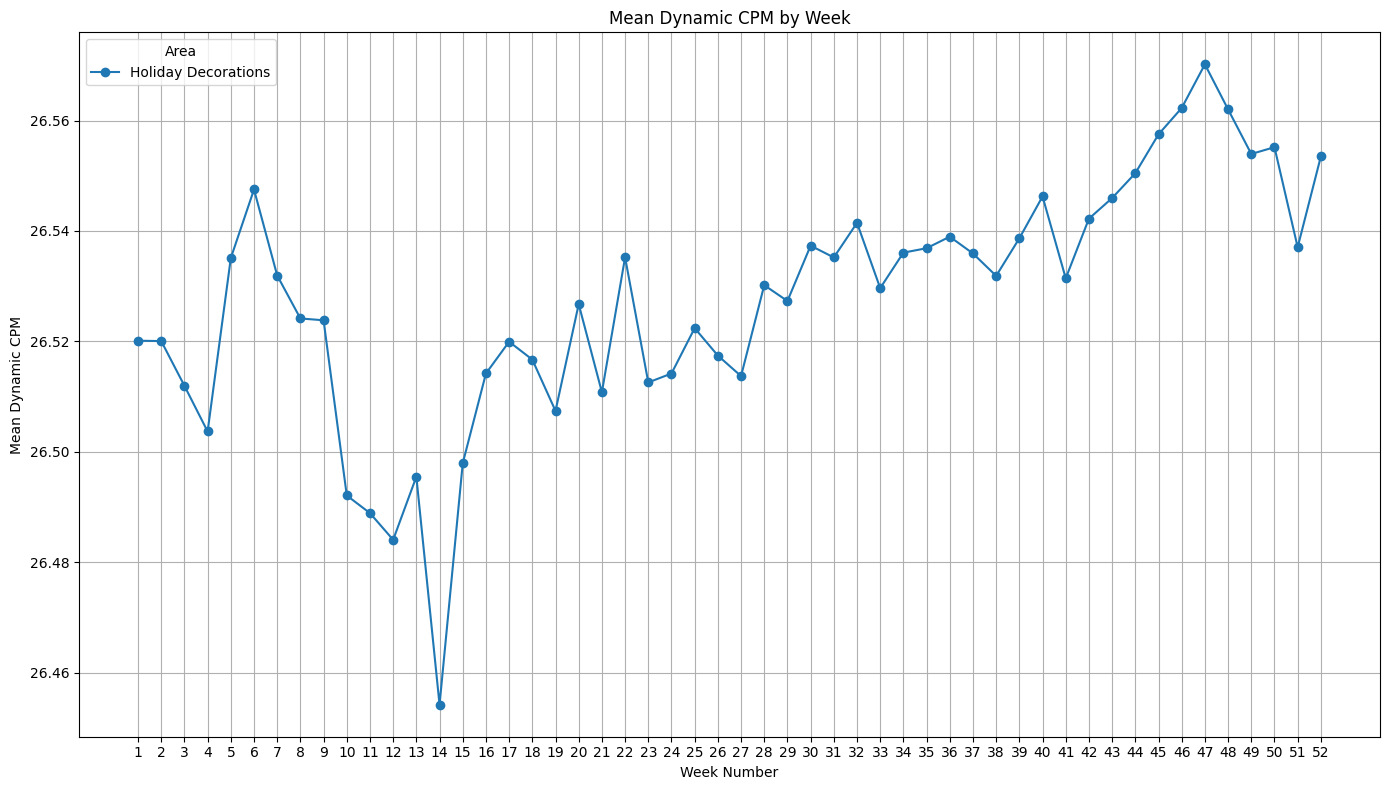

In [132]:

#Holiday data with dynamic pricing
variability_by_area = holiday_data.groupby(['area', 'week_num'])['dynamic_cpm'].mean().reset_index()


# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='dynamic_cpm')
    pivot_tables[area] = pivot_table

#plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area}')

plt.title('Mean Dynamic CPM by Week')
plt.xlabel('Week Number')
plt.ylabel('Mean Dynamic CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


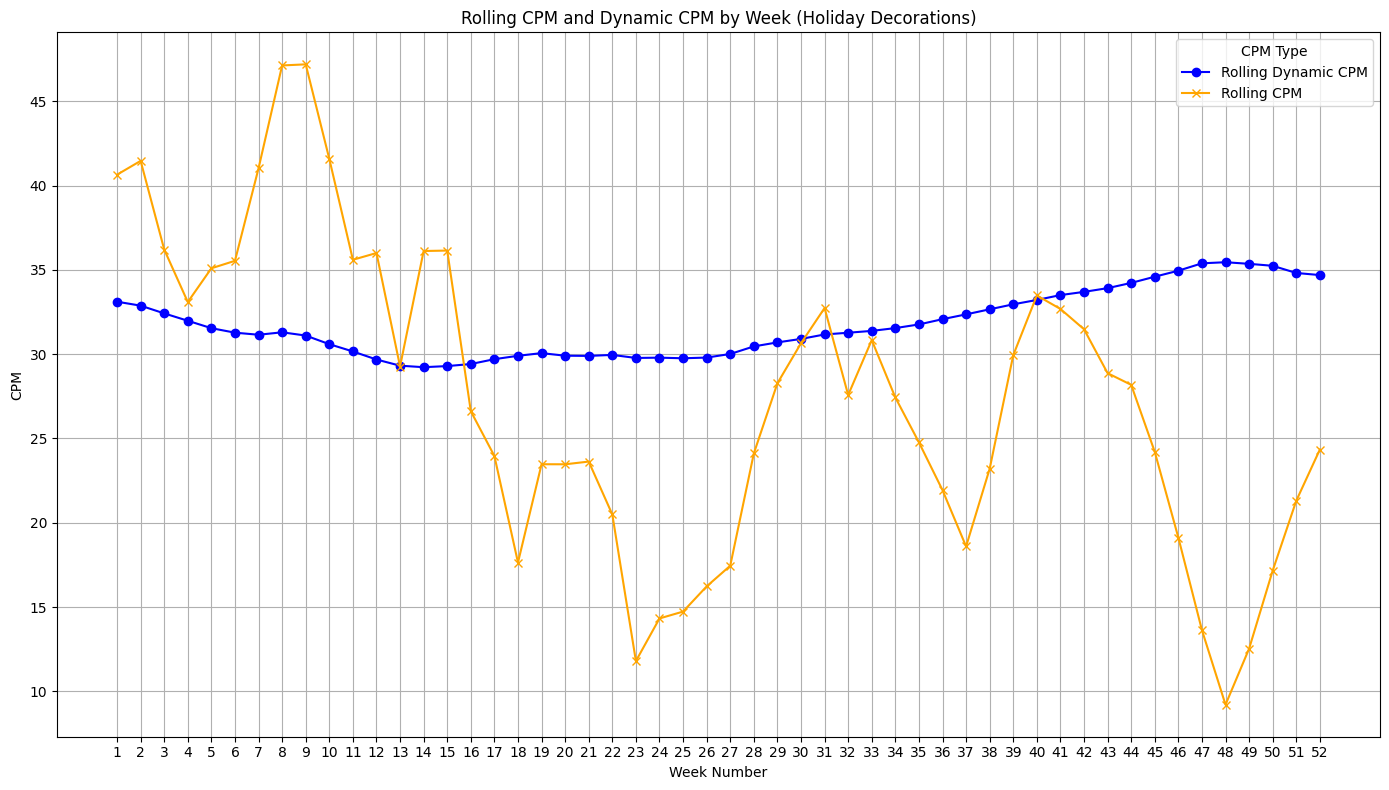

In [165]:



#Filter
data_2023 = efficiency_data[(efficiency_data['year'] == 2023) & (efficiency_data['area'] == 'Holiday Decorations')]

#Averages
variability_by_area = data_2023.groupby('week_num').agg({
    'cpm': 'mean',
    'dynamic_cpm': 'mean'
}).reset_index()

#Rolling
window_size = 4  # You can adjust this window size
variability_by_area['rolling_dynamic'] = variability_by_area['dynamic_cpm'].rolling(window=window_size, min_periods=1).mean()
variability_by_area['rolling_cpm'] = variability_by_area['cpm'].rolling(window=window_size, min_periods=1).mean()

#Plot
plt.figure(figsize=(14, 8))


plt.plot(variability_by_area['week_num'], variability_by_area['rolling_dynamic'], marker='o', label='Rolling Dynamic CPM', color='blue')

plt.plot(variability_by_area['week_num'], variability_by_area['rolling_cpm'], marker='x', label='Rolling CPM', color='orange')


plt.title('Rolling CPM and Dynamic CPM by Week (Holiday Decorations)')
plt.xlabel('Week Number')
plt.ylabel('CPM')
plt.legend(title='CPM Type')
plt.grid(True)
plt.xticks(ticks=variability_by_area['week_num'])  
plt.tight_layout()


plt.show()


### All areas Dynamic Pricing test

In [137]:
#Apply dynamic pricing to holiday data

all_areas_2023 = efficiency_data[(efficiency_data['year'] == 2023)]


# Calculate traffic percentiles
high_traffic_threshold = np.percentile(all_areas_2023['traffic'], 80)  # 80th percentile
low_traffic_threshold = np.percentile(all_areas_2023['traffic'], 20)   # 20th percentile

print(f"High Traffic Threshold: {high_traffic_threshold}")
print(f"Low Traffic Threshold: {low_traffic_threshold}")

base_price = all_areas_2023['cpm'].mean()

#funcion to calculate pricing based on traffic
def dynamic_pricing_based_on_traffic(current_traffic, base_price):
   
    if current_traffic > high_traffic_threshold:
        
        scaling_factor = 1 + 0.02 * ((current_traffic - high_traffic_threshold) / (all_areas_2023['traffic'].max() - high_traffic_threshold)) ** 2
        price = base_price * min(scaling_factor, 2.0)  
    elif current_traffic < low_traffic_threshold:
       
        scaling_factor = 1 - 0.02 * ((low_traffic_threshold - current_traffic) / low_traffic_threshold) ** 2
        price = base_price * max(scaling_factor, 0.5) 
    else:
        price = base_price  

    return price

# Apply the dynamic pricing function
all_areas_2023['dynamic_cpm'] = all_areas_2023['traffic'].apply(lambda x: dynamic_pricing_based_on_traffic(x, base_price))
all_areas_2023.head()

High Traffic Threshold: 52791.600000000006
Low Traffic Threshold: 2729.0


,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin,dpi,ad_spend_traffic,dynamic_cpm
212494,2023-01-02,Tools|Power Tools|Power Multi Tools|Rotary Tools,94258.0,35350.0,14847.0,38.0,565291.0,10.0,10175231.0,2023,1,2023-01,1,17.999988,16.999988,0.000004,Tools,2.631579,685.339193,15.991259,30.343339
205937,2023-01-02,Tools|Power Tool Accessories|Saw Blades|Band S...,94197.0,31278.0,16265.0,34.0,560030.0,10.0,10080540.0,2023,1,2023-01,1,18.000000,17.000000,0.000003,Tools,2.941176,619.768829,17.904917,30.343339
77289,2023-01-02,Outdoors|Garden Center|Ponds & Pond Accessorie...,92856.0,11944.0,5733.0,37.0,213519.0,7.0,4910930.0,2023,1,2023-01,1,22.999967,21.999967,0.000008,Outdoors,2.702703,856.607361,17.876674,30.343339
123749,2023-01-02,Outdoors|Patio Furniture|Outdoor Lounge Furnit...,93229.0,5555.0,2889.0,56.0,161572.0,7.0,5008721.0,2023,1,2023-01,1,30.999932,29.999932,0.000011,Outdoors,1.785714,1733.721357,29.085869,30.343339
160753,2023-01-02,Plumbing|Plumbing Parts|Toilet Parts,93832.0,37070.0,21501.0,42.0,894302.0,8.0,16991735.0,2023,1,2023-01,1,18.999997,17.999997,0.000002,Plumbing,2.380952,790.276499,24.124683,30.343339


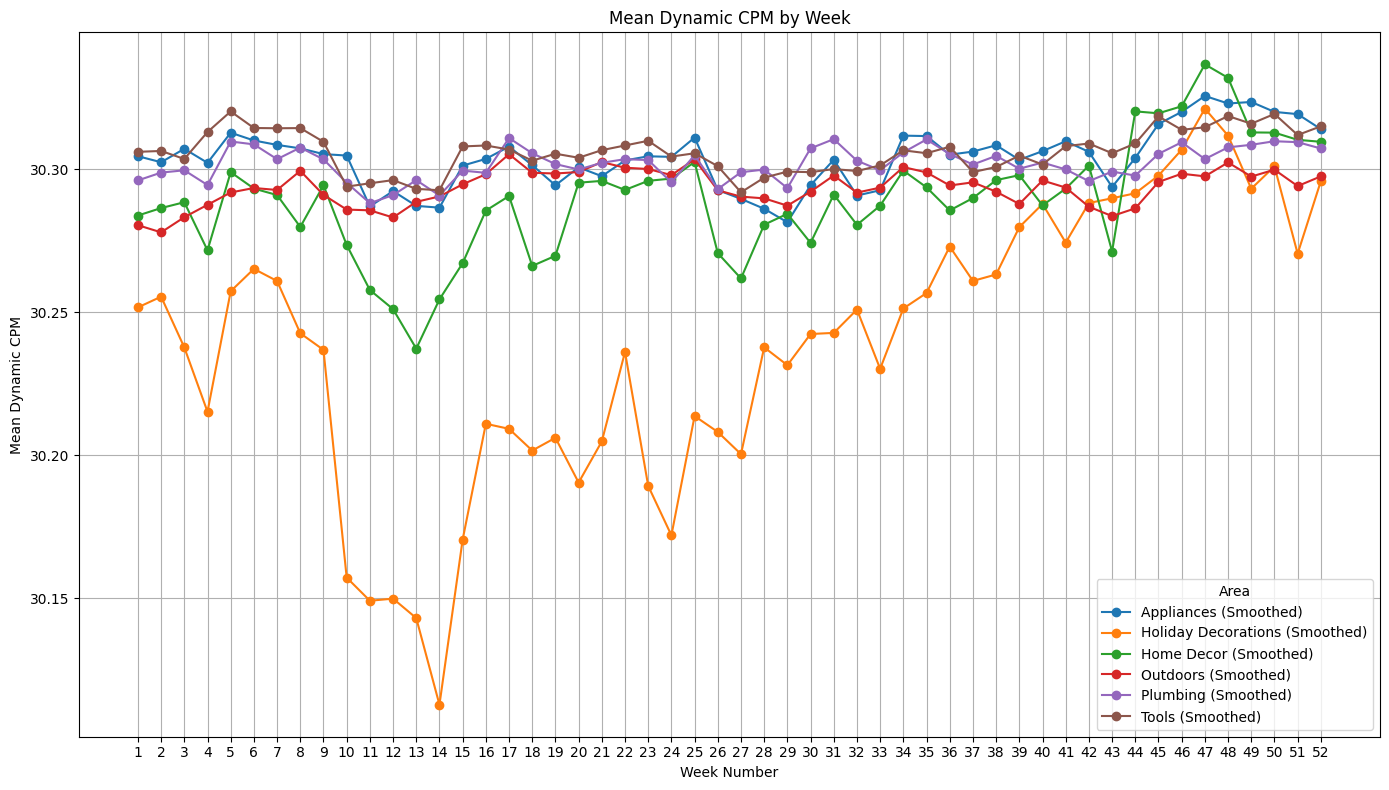

In [140]:
#all area CPMs per week

# weekly variability
variability_by_area = all_areas_2023.groupby(['area', 'week_num'])['dynamic_cpm'].mean().reset_index()


# pivot
pivot_tables = {}
for area in variability_by_area['area'].unique():
    area_data = variability_by_area[variability_by_area['area'] == area]
    pivot_table = area_data.pivot(index='week_num', columns='area', values='dynamic_cpm')
    pivot_tables[area] = pivot_table

# plot
plt.figure(figsize=(14, 8))
for area, pivot_table in pivot_tables.items():
    plt.plot(pivot_table.index, pivot_table[area], marker='o', label=f'{area} (Smoothed)')

plt.title('Mean Dynamic CPM by Week')
plt.xlabel('Week Number')
plt.ylabel('Mean Dynamic CPM')
plt.legend(title='Area')
plt.grid(True)
plt.xticks(ticks=pivot_tables[list(pivot_tables.keys())[0]].index)  
plt.tight_layout()
plt.show()


### Calculate a new ad spend dollar amount

In [147]:
# Correct for CPM being cost per thousand impressions
pd.set_option('display.float_format', lambda x: '%.2f' % x)
all_areas_2023['new_ad_spend'] = (all_areas_2023['dynamic_cpm']) * all_areas_2023['ad_impressions']
all_areas_2023.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin,dpi,ad_spend_traffic,dynamic_cpm,new_ad_spend
212494,2023-01-02,Tools|Power Tools|Power Multi Tools|Rotary Tools,94258.00,35350.00,14847.00,38.00,565291.00,10.00,10175231.00,2023,1,2023-01,1,18.00,17.00,0.00,Tools,2.63,685.34,15.99,30.34,450507.56
205937,2023-01-02,Tools|Power Tool Accessories|Saw Blades|Band S...,94197.00,31278.00,16265.00,34.00,560030.00,10.00,10080540.00,2023,1,2023-01,1,18.00,17.00,0.00,Tools,2.94,619.77,17.90,30.34,493534.41
77289,2023-01-02,Outdoors|Garden Center|Ponds & Pond Accessorie...,92856.00,11944.00,5733.00,37.00,213519.00,7.00,4910930.00,2023,1,2023-01,1,23.00,22.00,0.00,Outdoors,2.70,856.61,17.88,30.34,173958.36
123749,2023-01-02,Outdoors|Patio Furniture|Outdoor Lounge Furnit...,93229.00,5555.00,2889.00,56.00,161572.00,7.00,5008721.00,2023,1,2023-01,1,31.00,30.00,0.00,Outdoors,1.79,1733.72,29.09,30.34,87661.91
160753,2023-01-02,Plumbing|Plumbing Parts|Toilet Parts,93832.00,37070.00,21501.00,42.00,894302.00,8.00,16991735.00,2023,1,2023-01,1,19.00,18.00,0.00,Plumbing,2.38,790.28,24.12,30.34,652412.14


In [148]:
#End of Year CPM data
eoy_cpm = all_areas_2023.query('week_num >= 40')
eoy_cpm.head()

,date,taxonomy,campaign_id,traffic,ad_impressions,cpm,ad_spend,booking_lead_time,sales,year,month,year_month,week_num,roas,roi,cpm_ratio,area,margin,dpi,ad_spend_traffic,dynamic_cpm,new_ad_spend
19106,2023-10-02,Appliances|Small Kitchen Appliances|Specialty ...,165716.00,12984.00,6882.00,62.00,426959.00,9.00,11527882.00,2023,10,2023-10,40,27.00,26.00,0.00,Appliances,1.61,1675.08,32.88,30.34,208822.86
71583,2023-10-02,Outdoors|Garden Center|Pest Control|Insect Con...,164848.00,3781.00,1928.00,70.00,134159.00,10.00,1878222.00,2023,10,2023-10,40,14.00,13.00,0.00,Outdoors,1.43,974.18,35.48,30.34,58501.96
194176,2023-10-02,Tools|Hand Tools|Pliers|Plier Sets,166099.00,14867.00,6987.00,45.00,314893.00,13.00,9761680.00,2023,10,2023-10,40,31.00,30.00,0.00,Tools,2.22,1397.12,21.18,30.34,212008.91
73716,2023-10-02,Outdoors|Garden Center|Plant Seeds|Fruit Seeds,164874.00,1380.00,814.00,38.00,30939.00,11.00,556902.00,2023,10,2023-10,40,18.00,17.00,0.00,Outdoors,2.63,684.15,22.42,30.20,24578.77
219085,2023-10-02,Tools|Safety & Security|Safes|Lock Boxes|Key L...,166369.00,33530.00,11400.00,27.00,313494.00,10.00,10345312.00,2023,10,2023-10,40,33.00,32.00,0.00,Tools,3.70,907.48,9.35,30.34,345914.07


In [150]:
eoy_cpm = all_areas_2023[['week_num', 'cpm', 'ad_spend', 'dynamic_cpm', 'new_ad_spend']]
eoy_cpm.head()

,week_num,cpm,ad_spend,dynamic_cpm,new_ad_spend
212494,1,38.00,565291.00,30.34,450507.56
205937,1,34.00,560030.00,30.34,493534.41
77289,1,37.00,213519.00,30.34,173958.36
123749,1,56.00,161572.00,30.34,87661.91
160753,1,42.00,894302.00,30.34,652412.14


In [156]:
#New Ad Spend values comparison by week

eoy = all_areas_2023.query('week_num >=1')
eoy = eoy[['week_num', 'cpm', 'ad_spend', 'dynamic_cpm', 'new_ad_spend']]
# eoy_mean = eoy.groupby('week_num')['cpm'].mean().reset_index()
eoy_mean = eoy.groupby('week_num').agg({
    'cpm': 'mean',
    'dynamic_cpm': 'mean',
     'ad_spend':'mean',
     'ad_spend':'sum',
     'new_ad_spend':'mean',
     'new_ad_spend': 'sum'
}).reset_index()
eoy_mean

,week_num,cpm,dynamic_cpm,ad_spend,new_ad_spend
0,1,47.24,30.29,1673828037.00,1055652548.23
1,2,48.70,30.29,1916794488.00,1141649516.66
2,3,33.30,30.29,1290194571.00,1042761422.67
3,4,29.03,30.29,1424977878.00,1122806546.38
4,5,50.47,30.30,1924566240.00,1121300785.00
5,6,49.31,30.30,2089047768.00,1181066218.69
6,7,50.09,30.30,2176976678.00,1162863825.42
7,8,49.79,30.30,2105744382.00,1164680618.39
8,9,49.17,30.30,1607578046.00,942935614.81
9,10,26.44,30.29,1113358406.00,947003975.07


In [152]:
#Mean description of new figures
eoy_mean.describe()

,week_num,cpm,dynamic_cpm,ad_spend,new_ad_spend
count,52.00,52.00,52.00,52.00,52.00
mean,26.50,30.45,30.30,1451538381.46,1313915523.84
std,15.15,13.64,0.01,472668632.24,228323056.53
min,1.00,11.67,30.28,649513792.00,906463169.93
25%,13.75,14.73,30.29,1045203095.50,1157560248.23
50%,26.50,32.69,30.30,1556244283.00,1284109361.36
75%,39.25,39.01,30.30,1765200354.00,1431148099.58
max,52.00,50.47,30.31,2428056778.00,2014895662.88


In [153]:
#New sums for ad spend
print(eoy_mean['ad_spend'].sum())
print(eoy_mean['new_ad_spend'].sum())

75479995836.0
68323607239.46201
